<a href="https://colab.research.google.com/github/tlmakinen/CEH/blob/main/spares_reg_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SKIM Pairwise Sparse Regression for exploratory data

Here we'll introduce a (modified) implementation of the paper [The Kernel Interaction Trick: Fast Bayesian Discovery of Pairwise Interactions in High Dimensions](https://arxiv.org/abs/1905.06501) by Agrawal et al. (2019). We'll walk through what we seek to learn from unmapped high-dimensional data, and apply it to both a toy and exploratory example using (circa April 2020) COVID-19 data. 

---

## Sparse Interactions
 
- What are sparse interactions ? 

In high dimensional data (such as hologenomic datasets), researchers are posed with an issue: which aspects or measurements of a dataset form the best predictors for a given observable ? In systems with as many variables as biological experiments, searching for sparse interactions between dataset features can help researchers narrow down analyses to the most important aspects of their data. For instance, human genomic data can contain records of hundreds of active genes, but the observable, e.g. a specific hair color, might only be the result of the presence of a single gene.

- How do we fit dataset features ?

Let's consider, as Agrawal et al. do, a dataset $\mathcal{D} = \{(x^{(n)}, y^{(n)}) \}_{n=1}^{N}$ with $N$ feature vectors (covariates) $x^{(n)} \in \mathbb{R}^p$ and $N$ real-valued responses, or observables $y^{(n)} \in \mathbb{R}$. 
  
The naïve solution is to construct linear relationships between a set of features $\{x \}_i$ 
 $i=1, \dots, p$, and a given outcome, $y$. However, in practice one often encounters scenarios where a *combination* of features is in fact the best predictor for $y$. The natural thing to do is expand the regression problem to the system
$$ \Phi^T_2(x) = [1 + x_1 + \dots + x_p + x_1x_2 +\dots + x_{p-1}x_p, x^2_1, \dots, x^2_p] $$
which considers all pairwise and quadratic terms in the expansion. The regression then boils down to finding coefficients $\theta \in \mathcal{R}^{p(p+1)/2}$ for all terms, yielding a predictive model
$$y^{(n)} = \theta^T \Phi_2 (x^{(n)}) + \epsilon^{(n)} $$

Where $\epsilon^{(n)}$ are zero-centered i.i.d. errors. We're now interested in figuring out which interaction terms best describe the response. By encouraging sparsity (assuming only a few covariates explain the response), the problem becomes at once *easier* statistically, but *harder* computationally, since maximizing a likelihood for $\theta$ with sparse $L_1$ constraints takes $\mathcal{O}(np^2)$ time.

---

## Bayesian Interaction Sampling
Fortunately, Bayesian hierarchical methods incorporate model shrinkage naturally, even if they are computationally expensive in a naïve setting. We're interested in recovering the posterior distribution for our coefficients $\theta$, given as:
$$ p(\theta | \mathcal{D}) \propto \mathcal{L}(Y | \theta, X) p(\theta) $$
where $\mathcal{L}(Y | \theta, X)$ is the likelihood of seeing observable $Y$ given model parameters, and $p(\theta)$ is the prior, or an encoding of the state of knowledge about the parameters *before* observing the data.

To do this, we need to posit a generative model for the data. The SKIM model assumes a Gaussian scale mixture model for $y$:
\begin{align}
\tau &\sim p(\tau) \\
\sigma^2 &\sim p(\sigma^2) \\
\theta | \tau &\sim \mathcal{N}(0, \Sigma_\tau) \\
y^{(n)} | x^{(n)}, \theta, \sigma^2 &\sim \mathcal{N}(\theta^T \Phi_2(x^{(n)}), \sigma^2)
\end{align}
 Where $\Sigma_\tau$ is the covariance matrix for $p(\theta | \tau)$. 
- Define linear + pairwise interaction terms
- introduce sampler + hierarchical model


## SKIM Model
The SKIM model presented by Agrawal et al. circumvents computational intractability in both the sparse and Bayesian settings by utilizing a Kernel Interaction sampler to highlight relevant features in the data, followed by the "Kernel Interaction Trick" to recover the posterior marginal distributions of the relevant active dimensions. Full details are given in the paper, but we'll proceed with a couple examples to illustrate the method in an exploratory setting. 
 
--

***

### How does the SKIM model promote sparsity ?

Based on Griffin and Brown (2017), hierarchical priors in Bayesian regression are dependent on the size of the coefficients, where the hyperparameters control for shrinkage of coefficients similar to a penalty term. In particular, a small estimated variance in coefficients would enforce some shrinkage and likely yield a sparser model. The Gaussian scale mixture is just a special case of hierarchical priors, in which $\tau$ and $\Sigma_\tau$ control the shrinkage of $\theta$. The SKIM model, in particular, has the form
\begin{align}
\kappa \sim p(\kappa)&, \quad \eta \sim p(\eta), \quad c^2 \sim p(c^2) \\
 \theta_{x_i} | \kappa, \nu &\sim \mathcal{N}(0,\eta_{1}^{2} \kappa_{i}^{2}) \quad \text{independent for} \quad i\in\{1,...,p\}, \\
\theta_{x_i x_j} | \kappa, \eta &\sim \mathcal{N}(0, \eta_{2}^{2}\kappa_{i}^{2}k_{j}^{2}) \quad \text{independent for} \quad i,j\in\{1,...,p\}, i \neq j, \\
\theta_{x_{i}^{2}} | \kappa,\eta &\sim \mathcal{N}(0,\eta_{3}^{2}\kappa_{i}^{4}) \quad \text{independent for}\quad i\in\{1,...,p\}, \\
\theta_{0}|c^2 &\sim \mathcal{N}(0,c^2).
\end{align}

The pdfs $p(\kappa), p(\nu)$ and $p(c^2)$ are usually chosen to be heavy-tailed. 

First, the model above promotes sparsity on the parameter $\theta_{x_i}$ for $i\in\{1,...,p\}$. The parameter $\eta_1$ controls the overall sparsity level of the $\theta_{x_i}$. If $\eta_1$ is small, then, $\eta_{1}^{2}\kappa_{i}^{2}$ tends to be small for each $i\in\{1,...,p\}$, leading to a very high probability mass of the normal density of $\theta_{x_i}$ around zero. Therefore, realizations of $\theta_{x_i}$ where $|\theta_{x_i}|$ is small tend to be more likely. The parameter $\kappa_i$, which is usually drawn from a heavy-tail distribution, controls for the local sparsity and can then overcome the global shrinkage induced on $\theta_{x_i}$ by $\eta_1$ if the realization of $\kappa_i$ is large enough. If the realization of $\kappa_i$ is large enough, the variance $\eta_{1}^{2}\kappa_{i}^{2}$ of $\theta_{x_i}$ can become non-negligible, leading to a higher likelihood of non-zero values for $|\theta_{x_i}|$. 

Secondly, the model promotes sparisty by its hirarchy property. In this context, hirarchy means that an interaction terms $\theta_{x_i x_j}$  can only be relevant if both $\theta_{x_i}$ and $\theta_{x_j}$ are relevant. Thus, if at least one of the parameter $\theta_{x_i}$ or $\theta_{x_j}$ are shrunk to zero, the interaction term $\theta_{x_i x_j}$ is shrunk to zero too. This can be seen by observing that the variance of the interaction term $\theta_{x_i x_j}$ is given by $\eta_{2}^{2}\kappa_{i}^{2}\kappa_{j}^{2}$. If at least one of the local parameter $\kappa_{i}$ or $\kappa_j$ is small, then, the variance of $\eta_{2}^{2}\kappa_{i}^{2}\kappa_{j}^{2}$ will be small, leading to a high likelihood concentration of $\theta_{x_i x_j}$ around small values of $|\theta_{x_i x_j}|$. Here again, the parameter $\eta_2$ controls for the global sparsity of the interaction terms $\theta_{x_i x_j}$. We see the sparsity in $\theta_{x_i}$ are "inherited" via hirarchy to sparsity in $\theta_{x_i x_j}$. 

The above applies similarly for the quadratic terms $\theta_{x_i}^{2}$. If the local shrinkage parameter $\kappa_i$ tends to be small, then, the variance of $\theta_{x_i}^{2}$, which is given by $\eta_{3}^{2}\kappa_{i}^{4}$ will be small. Again, the parameter $\eta_3$ controls for the global sparsity of the interaction terms. 

<!-- ### Question 2:

This result is possible due to the Proposition 4.1 in Agrawal et al (2019), and the weight-space view of GP from Rasmussen and Williams (2006). The function $\Phi_2$ is designed such that it can be rewritten as a GP, namely the GP $g = \theta^T\Phi_2$. Then, for any draw $g|\tau\sim N(0,k_\tau)$, there exists a parameter vector $\theta$ such that $g=\theta^T\Phi_2$. The model in Eq (3) is equivalent to the model in Eq (6) for the right choice of the kernel function $k_\tau$ for the Gaussian Process $g|\tau \sim \text{GP}(0,k_\tau)$. The choice of the kernel function $k_\tau$ is
$$ k_\tau(x,x') = \Phi_{2}(x)^t \Sigma_\tau \Phi_{2}(x').$$

For such a choice, the model defined in Eq (3) is always equivalent to the model defined in Eq (6). However, for the proposed algorithm to work in the proposed time efficiency, we need to be able to evaluate $k_\tau$ in $O(p)$ time, where $p$ is the number of covariates. To do this, the papaer rewrites the kernel $k_\tau$ as a weighted sum of polynomial kernels. To do this, one one needs to require the variance-covariance matrix $\Sigma_\tau$ of the parameter $\theta$ to be diagonal.  -->

<!-- ### Question 3:

We can identify the following limitations to this paper:

* The implementation of the SKIM model is dependent on the choice of several hyperparameters that need to be selected by the user. Some of these hyperparameter are non-trivial to choose, but at the same time very important. For example, the SKIM model requires the user to select a hyperparameter $s$ which corresponds to the global sparsity of $\theta_{x_i}$. Furthermore, the $\kappa_i$'s are chosen from a truncated half-Cauchy distribution, in which one needs to specify a hyperparameter $m$ that corresponds to the truncation cutoff of the half-Cauchy distribution. Therefore, $m$ control indirectly for the heavy-tailness of $p(\kappa)$ and therefore, for the local sparsity on $\theta_{x_i}$. Similar hyperparameter have to be chosen for the interaction terms $\theta_{x_i x_j}$ and the squared terms $\theta_{x_i}^{2}$. Overall, to sum it up, there are several hyperparameters to select and the choice is not trivial. 

* The implementation of the SKIM model in the paper requires the variance-covariance matrix $\Sigma_\tau$ of the prior of the parameter $\theta$ to be diagonal. Therefore, it is impossible to incorporate correlations between different components of $\theta$ in the prior. 

* The SKIM method implies hirarchy. This is, an interaction parameter $\theta_{x_i x_j}$ is always negligable if at least one of the parameter $\theta_{x_i}$ and $\theta_{x_j}$ is negligable. This is a desirable property in many applications. However, in certain applications, this property might not be desirable. Consider a situation in which both variables $x_i$ and $x_j$ do not directly influence the target variable $y$, however, their interaction term $x_i x_j$ has strong predictive power. This situation cannot be reflected by the SKIM method. 
    - For a specific example, in the discussion of Priors for Related Predictors in Chipman (1996), one practical instance in which the strong hierarchy property would fail is in atmospheric sciences. A key relation is $log(Y)=log(A)+BC$, in which the interaction term $BC$ would not satisfy strong hierarchy, and thus could not be properly modeled using this approach. 

* The SKIM method, as implemented in the paper, takes $O(pN^2 + N^3)$ time to compute, where $N$ denotes the number of observations and $p$ the number of covariates. It has the nice property of scaling linearly in $p$, which makes the method applicable to situations in which $p$ is large. However, the method scales cubic in $N$. This limits the applicability of the method to situations in which $N$ is large. By comparison, the naive method requires $O(p^6 + p^4 N)$ time, which scales linearly in $N$ (but obviously, terrible in $p$). Furthermore, memory is quadratic with respect to $N$, which is only as good or even worse than the other sampling methods compared (NAIVE, WOODBURY, and FULL). 

* The method is based on sampling $\tau_1,...,\tau_T \sim p(\tau | D)$ iid. To do so, MCMC methods are used. Therefore, the drawback that are specific to MCMC methods apply to this method too. Particularly, these are deciding when convergence of the Monte Carlo chain underlying the MCMC process is reached, how to sparse out the MCMC chain to obtain approximately independent draws and deciding on hyperparameters and initial choices. 

* Another possible limitation is the reliance/assumption of pairwise interactions. On one hand, the dimension of the parameter space is increased from $p$ to $\frac{p(p+1)}{2}$, which could be extremely computationally expensive when $p$ is not even that large; on the other hand, there may be instances that involve higher-order polynomial interactions, and thus this model of at-most pairwise interactions could be too limited in its scope.  -->

***

### Implementing SKIM in jax / Numpyro

I've modified the code from this awesome
[post](https://pyro.ai/numpyro/examples/sparse_regression.html).


***

## Code Adaptation Response

### 1. Transfer the code and check for comparable result

First, we transfer the code to the notebook

In [1]:
!git clone https://github.com/tlmakinen/CEH.git

Cloning into 'CEH'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 18 (delta 3), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [2]:
cd CEH/covid_example/

/content/CEH/covid_example


In [7]:
!pip install numpyro

     |████████████████████████████████| 184kB 8.6MB/s 


In [8]:
!pip install corner

In [9]:
import argparse
import itertools
import os
import time

import numpy as onp

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import corner

def dot(X, Z):
    return np.dot(X, Z[..., None])[..., 0]


# The kernel that corresponds to our quadratic regressor. (According to prop 6.1)
def kernel(X, Z, eta1, eta2, c, jitter=1.0e-6):
    eta1sq = np.square(eta1)
    eta2sq = np.square(eta2)
    k1 = 0.5 * eta2sq * np.square(1.0 + dot(X, Z))
    k2 = -0.5 * eta2sq * dot(np.square(X), np.square(Z))
    k3 = (eta1sq - eta2sq) * dot(X, Z)
    k4 = np.square(c) - 0.5 * eta2sq
    if X.shape == Z.shape:
        k4 += jitter * np.eye(X.shape[0])
    return k1 + k2 + k3 + k4


# Most of the model code is concerned with constructing the sparsity inducing prior.
def model(X, Y, hypers):
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    # S -  sparsity coeff
    S, P, N = hypers['expected_sparsity'], X.shape[1], X.shape[0]

    # sample variables from p. 18
    sigma = numpyro.sample("sigma", dist.HalfNormal(hypers['alpha3']))
    phi = sigma * (S / np.sqrt(N)) / (P - S)
    eta1 = numpyro.sample("eta1", dist.HalfCauchy(phi))

    msq = numpyro.sample("msq", dist.InverseGamma(hypers['alpha1'], hypers['beta1']))
    xisq = numpyro.sample("xisq", dist.InverseGamma(hypers['alpha2'], hypers['beta2']))

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq

    lam = numpyro.sample("lambda", dist.HalfCauchy(np.ones(P)))
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    # sample observation noise
    var_obs = numpyro.sample("var_obs", dist.InverseGamma(hypers['alpha_obs'], hypers['beta_obs']))

    # compute kernel (as in proposition 6.1)
    kX = kappa * X
    k = kernel(kX, kX, eta1, eta2, hypers['c']) + var_obs * np.eye(N)
    assert k.shape == (N, N)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=np.zeros(X.shape[0]), covariance_matrix=k),
                   obs=Y)

    
    

# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, msq, lam, eta1, xisq, c, var_obs):
    P, N = X.shape[1], X.shape[0]

    probe = np.zeros((2, P))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dimension], np.array([1.0, -1.0]))

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = np.array([0.50, -0.50]) ## a = (1/2, -1/2)
    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.dot(mu, vec)

    var = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    var = np.matmul(var, vec)
    var = np.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam, eta1, xisq, c, var_obs):
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    P, N = X.shape[1], X.shape[0]

    probe = np.zeros((4, P))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dim1], np.array([1.0, 1.0, -1.0, -1.0]))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dim2], np.array([1.0, -1.0, 1.0, -1.0]))
    
    
    # compute eta2 and kappa from p. 18 

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    # ?? compute a bunch of matrices w/ kernels ??
    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = np.array([0.25, -0.25, -0.25, 0.25]) ## ?? not sure why not (-1/2, 1/2, -1, 1) ??
    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.dot(mu, vec)

    var = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    var = np.matmul(var, vec)
    var = np.dot(var, vec)

    return mu, var


# Sample coefficients theta from the posterior for a given MCMC sample.
# The first P returned values are {theta_1, theta_2, ...., theta_P}, while
# the remaining values are {theta_ij} for i,j in the list `active_dims`,
# sorted so that i < j.
def sample_theta_space(X, Y, active_dims, msq, lam, eta1, xisq, c, var_obs): #(section B.5) ?
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    # and number of active dimensions
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = np.zeros((2 * P + 2 * M * (M - 1), P))
    vec = np.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 2, dim], np.array([1.0, -1.0]))
        vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 2], np.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim1],
                                         np.array([1.0, 1.0, -1.0, -1.0]))
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim2],
                                         np.array([1.0, -1.0, 1.0, -1.0]))
            vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 4],
                                       np.array([0.25, -0.25, -0.25, 0.25]))
            start1 += 4
            start2 += 1

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.sum(mu * vec, axis=-1)

    covar = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    covar = np.matmul(vec, np.matmul(covar, np.transpose(vec)))
    L = np.linalg.cholesky(covar)

    # sample from N(mu, covar)
    sample = mu + np.matmul(L, onp.random.randn(num_coefficients))

    return sample


# Helper function for doing HMC inference
def run_inference(model, args, rng_key, X, Y, hypers):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args.num_warmup, args.num_samples, num_chains=args.num_chains,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y, hypers)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = np.mean(mus)
    mean_var = np.mean(variances) + np.mean(np.square(mus)) - np.square(mean_mu)
    return mean_mu, mean_var


# Create artificial regression dataset where only S out of P feature
# dimensions contain signal and where there is a single pairwise interaction
# between the first and second dimensions.
def get_data(N=20, S=2, P=10, sigma_obs=0.05):
    assert S < P and P > 1 and S > 0
    onp.random.seed(0)

    X = onp.random.randn(N, P)
    # generate S coefficients with non-negligible magnitude
    W = 0.5 + 2.5 * onp.random.rand(S)
    # generate data using the S coefficients and a single pairwise interaction
    Y = onp.sum(X[:, 0:S] * W, axis=-1) + X[:, 0] * X[:, 1] + sigma_obs * onp.random.randn(N)
    Y -= np.mean(Y)
    Y_std = np.std(Y)

    assert X.shape == (N, P)
    assert Y.shape == (N,)

    return X, Y / Y_std, W / Y_std, 1.0 / Y_std


# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, hypers):
    vmap_args = (samples['msq'], samples['lambda'], samples['eta1'], samples['xisq'], samples['var_obs'])
    mus, variances = vmap(lambda msq, lam, eta1, xisq, var_obs:
                          compute_singleton_mean_variance(X, Y, dimension, msq, lam,
                                                          eta1, xisq, hypers['c'], var_obs))(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = np.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, hypers):
    vmap_args = (samples['msq'], samples['lambda'], samples['eta1'], samples['xisq'], samples['var_obs'])
    mus, variances = vmap(lambda msq, lam, eta1, xisq, var_obs:
                          compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam,
                                                         eta1, xisq, hypers['c'], var_obs))(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = np.sqrt(variance)
    return mean, std

def main(args):
    X, Y, expected_thetas, expected_pairwise = get_data(N=args.num_data, P=args.num_dimensions,
                                                        S=args.active_dimensions)

    # setup hyperparameters
    hypers = {'expected_sparsity': max(1.0, args.num_dimensions / 10),
              'alpha1': 3.0, 'beta1': 1.0,
              'alpha2': 3.0, 'beta2': 1.0,
              'alpha3': 1.0, 'c': 1.0,
              'alpha_obs': 3.0, 'beta_obs': 1.0}

    # do inference
    rng_key = random.PRNGKey(0)
    samples = run_inference(model, args, rng_key, X, Y, hypers)

    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(np.arange(args.num_dimensions))

    print("Coefficients theta_1 to theta_%d used to generate the data:" % args.active_dimensions, expected_thetas)
    print("The single quadratic coefficient theta_{1,2} used to generate the data:", expected_pairwise)
    active_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            active_dimensions.append(dim)
        print("[dimension %02d/%02d]  %s:\t%.2e +- %.2e" % (dim + 1, args.num_dimensions, inactive, mean, std))

    print("Identified a total of %d active dimensions; expected %d." % (len(active_dimensions),
                                                                        args.active_dimensions))

    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    if len(active_dimensions) > 0:
        dim_pairs = np.array(list(itertools.product(active_dimensions, active_dimensions)))
        means, stds = vmap(lambda dim_pair: analyze_pair_of_dimensions(samples, X, Y,
                                                                       dim_pair[0], dim_pair[1], hypers))(dim_pairs)
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            lower, upper = mean - 3.0 * std, mean + 3.0 * std
            if not (lower < 0.0 and upper > 0.0):
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))

        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # final MCMC sample obtained from the HMC sampler.
        thetas = sample_theta_space(X, Y, active_dimensions, samples['msq'][-1], samples['lambda'][-1],
                                    samples['eta1'][-1], samples['xisq'][-1], hypers['c'], samples['var_obs'][-1])
        print("Single posterior sample theta:\n", thetas)


Next, we check that we can execute the example from the website and get a comparable result

In [ ]:
if __name__ == "__main__":
    #assert numpyro.__version__.startswith('0.2.4')
    parser = argparse.ArgumentParser(description="Gaussian Process example")
    parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
    parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
    parser.add_argument("--num-chains", nargs='?', default=1, type=int)
    parser.add_argument("--num-data", nargs='?', default=100, type=int)
    parser.add_argument("--num-dimensions", nargs='?', default=20, type=int)
    parser.add_argument("--active-dimensions", nargs='?', default=3, type=int)
    parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')
    args = parser.parse_args(args=[])

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)

    main(args)

sample: 100%|██████████| 1500/1500 [00:43<00:00, 34.22it/s, 15 steps of size 2.11e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.00      0.00      0.00      0.00      0.01    341.62      1.00
 lambda[0]    752.16   4165.30    243.19     13.83   1233.48    798.64      1.00
 lambda[1]   1273.33   5753.31    259.82     26.73   1551.21    317.84      1.00
 lambda[2]     97.97    437.09     50.58      7.52    161.28    555.84      1.00
 lambda[3]      1.21      1.78      0.71      0.00      2.66    580.02      1.00
 lambda[4]      1.28      1.78      0.71      0.00      2.93    903.97      1.00
 lambda[5]      1.10      1.63      0.69      0.00      2.30    645.40      1.00
 lambda[6]      1.28      1.76      0.74      0.00      2.85   1115.83      1.00
 lambda[7]      1.21      1.74      0.75      0.00      2.75   1062.02      1.00
 lambda[8]      1.18      1.51      0.73      0.00      2.71   1022.16      1.00
 lambda[9]      1.15      1.38      0.72      0.00      2.56   1001.35      1.00
lambda[10]      1.26      2

From the website, we see they ge the following result with the first 3 dimensions and a pairwise interaction between 1 and 2 identified as active.

```python
Identified a total of 3 active dimensions; expected 3.
Identified pairwise interaction between dimensions 1 and 2: 4.53e-01 +- 2.15e-02
```

We also obtain these results as can be seen above. Thus, we can proceed to the next step. Note that we obtain nan values for the single posterior sample theta because the code is not yet adapted, which we will do now.

### 2. Modify `sample_theta_space()`

Next, we modify the method `sample_theta_space()` to return flat posterior samples from the MCMC only for the active direct and pairwise interaction terms.

In [ ]:
def sample_theta_space_modified(X, Y, active_dims, msq, lam, eta1, xisq, c, var_obs, N_samps, dim_pair_arr): 
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    
    num_coefficients = P + M * (M - 1) // 2

    probe = np.zeros((2 * P + 2 * M * (M - 1), P))
    vec = np.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 2, dim], np.array([1.0, -1.0]))
        vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 2], np.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim1],
                                         np.array([1.0, 1.0, -1.0, -1.0]))
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim2],
                                         np.array([1.0, -1.0, 1.0, -1.0]))
            vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 4],
                                       np.array([0.25, -0.25, -0.25, 0.25]))
            start1 += 4
            start2 += 1

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.sum(mu * vec, axis=-1)

    covar = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    covar = np.matmul(vec, np.matmul(covar, np.transpose(vec)))
    L = np.linalg.cholesky(covar)
    
    #print("mu" + str(mu))
    #print("cov" + str(covar))
    
    # sample from N(mu, covar)
    sample = mu + np.matmul(L, onp.random.randn(num_coefficients))
    
    ####### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##########
    ####### ~~~~~~~~~~~~~ CHANGES to the original method ~~~~~~~~~~~~~~~~~~~ #########
    
    # include active direct and pairwise interactions terms only 
    all_active_dims = active_dims + dim_pair_arr
    mu_active = np.array([mu[i] for i in all_active_dims])
    
    cov_active = []
    for j in all_active_dims:
        cov_act_j = [covar[j][i] for i in all_active_dims]
        cov_active.append(cov_act_j)
    cov_active = onp.array(cov_active)
    
    # return posterior samples
    rng_key = random.PRNGKey(0)
    samps = numpyro.distributions.MultivariateNormal(loc = onp.array(mu_active), 
                                                     covariance_matrix = cov_active).sample(rng_key, sample_shape = (1, N_samps))

    samps_new = onp.reshape(samps, (N_samps, len(all_active_dims)))
    
    return samps_new


### 3. Modify `main()` method

Now, we modify the `main()` method to produce corner plots with posterior distributions.

In [ ]:
### X - parameters, Y - data points, {alpha_i, beta_i, c} - hyperparameters, 
### N_samps - number of samples for visualization with corner
def main_modified(X, Y, args, sigma = 3.0, alpha1 = 3.0, beta1 = 1.0, alpha2 = 3.0, beta2 = 1.0, 
                      alpha3 = 1.0, c = 1.0, alpha_obs = 3.0, beta_obs = 1.0, N_samps = 1000, labels=None):

    
    if labels == None:
        labs = [str(_) for _ in range(X.shape[1])]
    else:
        labs = labels
    
    # setup hyperparameters
    hypers = {'expected_sparsity': max(1.0, X.shape[1]/2),
              'alpha1': alpha1, 'beta1': beta1,
              'alpha2': alpha2, 'beta2': beta2,
              'alpha3': alpha3, 'c': c,
              'alpha_obs': alpha_obs, 'beta_obs': beta_obs}

    # do inference
    rng_key = random.PRNGKey(0)
    samples = run_inference(model, args, rng_key, X, Y, hypers)

    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(np.arange(X.shape[1]))
    num_dims = len(means)
    active_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
        lower, upper = mean - sigma * std, mean + sigma * std
        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            active_dimensions.append(dim)
        print("[dimension %02d/%02d]  %s:\t%.2e +- %.2e" % (dim + 1, X.shape[1], inactive, mean, std))

    print("Identified a total of %d active dimensions." % (len(active_dimensions)))
    
    
    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    if len(active_dimensions) > 0:
        
        dim_pairs = np.array(list(itertools.product(active_dimensions, active_dimensions)))
        means, stds = vmap(lambda dim_pair: analyze_pair_of_dimensions(samples, X, Y,
                                                                       dim_pair[0], dim_pair[1], hypers))(dim_pairs)
        # print(dim_pairs)
        dim_pair_arr = []
        dim_pair_index = num_dims -1
        dim_pair_name = []
        pair_labs = []
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            dim_pair_index += 1  
            lower, upper = mean - sigma * std, mean + sigma * std
            if not (lower < 0.0 and upper > 0.0):
                dim_pair_arr.append(dim_pair_index)
                dim_pair_name.append('%d and %d'%(dim1 + 1, dim2 + 1))
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))
                pair_labs.append(str(labs[dim1]) + ' and ' + str(labs[dim2]))
        
        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # final MCMC sample obtained from the HMC sampler.
        
        
        ####### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##########
        ####### ~~~~~~~~~~~~~ CHANGES to the original method ~~~~~~~~~~~~~~~~~~~ #########
        
        ## Get posterior samples from the sample_theta_space_modified() method
        thetas = sample_theta_space_modified(X, Y, active_dimensions, samples['msq'][-1], samples['lambda'][-1],
                                            samples['eta1'][-1], samples['xisq'][-1], hypers['c'], 
                                            samples['var_obs'][-1], N_samps, dim_pair_arr)
        print("Active dimensions: " + str(active_dimensions))
        
        ##  Visualize the posterior from the example with corner
        
        labels = ['dim '+str(i) for i in active_dimensions]
        active_dimensions = active_dimensions + dim_pair_arr
        if len(dim_pair_name) != 0:
            for n in range(len(dim_pair_name)):
                labels.append('dim ' + dim_pair_name[n])
        #fig = corner.corner(thetas, labels = labels);
        return active_dimensions, thetas, labels, pair_labs
    else:
        return active_dimensions, [], []


### 4. Check modified methods working properly

Finally, we check that the new `sample_theta_space_modified()` and `main_modified()` methods return expected results with the example from the website.

sample: 100%|██████████| 1500/1500 [00:57<00:00, 26.19it/s, 31 steps of size 1.63e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.01      0.00      0.00      0.00      0.01    719.96      1.00
 lambda[0]   1732.64  19517.37    219.79     19.19   1019.52    641.40      1.00
 lambda[1]   1220.87   5341.69    222.60     21.74   1412.39    249.90      1.00
 lambda[2]     66.29    100.05     43.62      6.02    124.25    481.41      1.00
 lambda[3]      1.12      1.46      0.69      0.00      2.45    738.84      1.00
 lambda[4]      1.25      1.69      0.76      0.01      2.65   1042.51      1.00
 lambda[5]      1.04      1.22      0.68      0.00      2.24    949.64      1.00
 lambda[6]      1.30      1.83      0.73      0.00      3.09   1222.55      1.00
 lambda[7]      1.18      2.14      0.67      0.00      2.68    877.72      1.00
 lambda[8]      1.14      1.68      0.65      0.00      2.56    786.23      1.00
 lambda[9]      1.14      1.54      0.71      0.00      2.52    922.90      1.00
lambda[10]      1.14      1

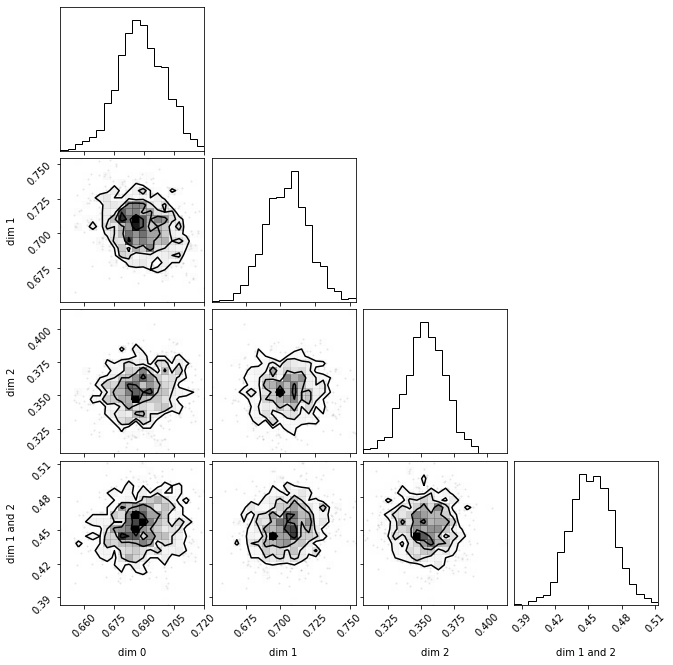

In [ ]:
if __name__ == "__main__":
    #assert numpyro.__version__.startswith('0.2.4')
    parser = argparse.ArgumentParser(description="Gaussian Process example")
    parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
    parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
    parser.add_argument("--num-chains", nargs='?', default=1, type=int)
    parser.add_argument("--num-data", nargs='?', default=100, type=int)
    parser.add_argument("--num-dimensions", nargs='?', default=20, type=int)
    parser.add_argument("--active-dimensions", nargs='?', default=3, type=int)
    parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')
    args = parser.parse_args(args=[])

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)
    X, Y, expected_thetas, expected_pairwise = get_data(N=args.num_data, P=args.num_dimensions,
                                                        S=args.active_dimensions)


    all_active_dimensions, thetas, labels, pair_labs = main_modified(X, Y, args)
    fig = corner.corner(thetas, labels = labels)

We again identify the same active dimensions and pairwise interactions. Additionally, the corner plots look sensible. With operational code, we can now proceed to the Application section.

***

### Application (4pts)

COVID-19 dominates the news, with many countries still reporting rising case numbers. One surprising fact is that the mortality rate (i.e. the fraction of the infected who have died, also called **case-fatality ratio**) differs *a lot* between countries, from 15% to less than 1%. Find out which features (such as age distribution, population health indices, economic factors, COVID-specific factors ...) influences that rate.

This task has three parts:

* Think about what possible effects there could be.
* Find suitable data for as many countries as possible in public data archives. Combine them into a master data set.
* Perform the inference.

You will probably need to iterate and refine along the way. Explain your reasoning about the kinds of features you decided to include in your analysis. Then report the most important direct and pairwise interactions. Visualized the posterior samples with `corner`.

**Note:** This is an exploratory study. If your approach is sound, but the data don't show firm trends, partial points will be awarded. Include your final data compilation as a separate file with your submission.

**Hints:** 

* Start [here](https://coronavirus.jhu.edu/data/mortality).
* Don't forget to standardize the data by subtracting the mean and dividing by the standard deviation.

***

## Application Response

### The Target Variable ($y$-variable)

The goal of this exercise is to identify explanatory variables that are expressive in the Covid-19 mortality rate across different countries. To do so, we consider a regression setup in which the Covid-19 mortatility rate is our target variable ($y$-variable). We interpret the realization of the target variable for any given country as an observation (or sample). 

We source the Covid-19 mortality rate across countries from the John-Hopkins website. We have the death rate available for a total of 144 countries. We take a first look into the $y$-variable which is the Covid-19 mortality rate.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
y_var = pd.read_csv("JHU_recent_mortality_by_country.csv", 
                    converters = {"Case-Fatality": lambda x: float(x.strip("%"))/100})

(y_var.head())

Country  Case-Fatality
0              US          0.059
1  United Kingdom          0.150
2           Italy          0.138
3           Spain          0.117
4          France          0.150

We derive the basic sample statistics for our target variable.

In [ ]:
y_var.describe()

Case-Fatality
count     144.000000
mean        0.047083
std         0.043048
min         0.001000
25%         0.018000
50%         0.035500
75%         0.061000
max         0.312000

We make the following observation:

* The standard-deviation of the mortality is relatively high.
* The mortality ranges from ~0.1% to ~30%. This is a very wide range.

We plot the histogram for the mortality to get a sense for the distribution of our target variable.

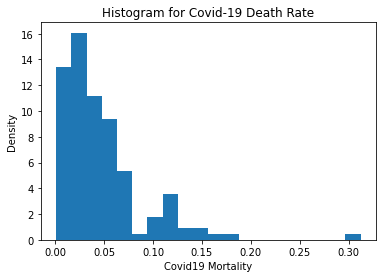

In [ ]:
plt.hist(y_var.iloc[:,1], density = True, bins = 20)
plt.ylabel("Density")
plt.xlabel("Covid19 Mortality")
plt.title("Histogram for Covid-19 Death Rate");

### The Explanatory Variables ($X$-data)

Our goal is to construct a regression model in which we predict the target variable. To do so, we need to come up with a set of explanatory variables that is expressive in predicting the Covid19 mortality rate. The data on the explanatory variables should be available for as many countries as possible, to create a data set of $X$-and $y$-data that is large enough.

Our approach is to come up with explanatory variables that we intuitively think are important to predict the Covid-19 rate. Then, we try to find data on these explanatory variables for as many countries as possible on the internet. We used the following sources for our data:

* World Health Organization (WHO),
* Wikipedia,
* worldindata.com,
* worldometer.com.

We source each explanatory variable from the internet in separate .csv files. Then, we use our data compilation code to combine all the different .csv files into one large .csv file, which we call "raw_data.csv". Please refer to the data compilation algorithm in the separate .ipynb file. 

Load the .csv file containing the combined data sets. 

In [ ]:
jhu = pd.read_csv("raw_data.csv")

These are the explanatory variables that we consider in order to predict the Covid19 mortality rate.

In [ ]:
pd.DataFrame(jhu.columns[2:], columns = ["Variables"])

Variables
0                       Human Development Index (HDI)
1                       Population median age (years)
2                                Adult mortality rate
3                    Life expectancy at birth (years)
4   Mortality rate attributed to exposure to unsaf...
5                   Population proportion over 60 (%)
6   Current health expenditure (CHE) per capita in...
7                 UHC index of service coverage (SCI)
8                             Cases per 1M population
9            Urban population (% of total population)
10                                diabetes_prevalence
11                             hospital_beds_per_100k
12                                     cvd_death_rate
13                                     GDP per capita
14                                      Tests/ 1M pop

In [ ]:
jhu.columns[2:].tolist()

['Human Development Index (HDI)',
 'Population median age (years)',
 'Adult mortality rate',
 'Life expectancy at birth (years)',
 'Mortality rate attributed to exposure to unsafe WASH services',
 'Population proportion over 60 (%)',
 'Current health expenditure (CHE) per capita in US$',
 'UHC index of service coverage (SCI)',
 'Cases per 1M population',
 'Urban population (% of total population)',
 'diabetes_prevalence',
 'hospital_beds_per_100k',
 'cvd_death_rate',
 'GDP per capita',
 'Tests/ 1M pop']

The explanatory variables that we consider can be classified as follows:

* Demographic data (population median age, population proportion over 60%, urban population),
* Economic indicators (GDP per capita),
* Health care related indicators (adult mortaility rate, life expectancy at birth, mortality rate attributed to exposure to unsafe washing practices, health care expenditure per capita, diabetes prevelance, hospital beds per capita, CVD death rate),
* Covid-19 related indicators (Coronavirus cases per capita, Covid19 test rate),
* Indices that reflect a combination of economic, heatlh care and demographic information (Human Development Index, UHC index).

The justifications for these variables are as follows:

- HDI: More developed countries are better equipped to handle a large-scale health crisis, so may be better able to reduce the mortality rate.
- Median age: COVID-19 appears to be affecting the elderly more than the young, so an older population may be more likely to have a higher mortality rate.
- Mortality rate: Deaths from COVID-19 might be mistaken for other causes (or vice versa) in the early reporting so there could be relationship between overall mortality rate and COVID-19 mortality rate. Also countries like Belgium are including deaths of people who have not been tested but are suspected of having had COVID-19 in their COVID-1 death tallies.
- Mortality rate (unsafe WASH): A key part of the COVID-19 prevention guidelines is regular and thorough washing / cleansing; thus, if a country already has deaths from poor access to water, sanitation, and hygiene services, it is more likely to be difficult to 'flatten the curve' in that country.
- Population 60+: Similar to median age.
- Current health expenditure (CHE): Countries that spend more on healthcare are perhaps more likely to be able to handle a large-scale health crisis.
- UHC index: Similar to CHE -- countries with better access to necessary health services are perhaps more likely to be able to handle a large-scale health crisis.
- Cases per 1M: This is (roughly) the denominator of the mortality rate so is closely linked. More cases may mean more moderate cases of COVID-19 have been found so the mortality rate may be lower. Alternatively, more cases may just mean the severity of the spread is higher and so the mortality rate could be higher because the pandemic is worse in that country.
- Urbanisation: More urban environments are more densely-packed and so contact / spread is more likely: people use public transport, live in apartment buildings, eat out at restaurants more, go to the same parks, etc.
- Diabetes: COVID-19 does affect the more vulnerable portions of the population more, but this is also one (rudimentary) indicator of the pre-COVID-19 health of the population: more diabetics might indicate a generally less healthy population.
- Hospital beds: The issues of insufficient hospital beds and ventilators and PPE have been all over the news for weeks as hospitals are overrun with COVID-19 patients. More hospital beds may indicate a country is better able to handle the pandemic and maybe also just better prepared generally.
- COVID-19 death rate: This is of course linked to the COVID-19 mortality rate, so we feel it could be a good explanatory variable.
- GDP: Similar to HDI.
- Tests / 1M: The number of tests relates to the number of cases as more tests will lead to more positive results. Additionally, more tests may indicate a country's responsiveness to the crisis.


As described above, the explanatory data is obtained from different sources from the internet. Depending on the source, the information on any given explanatory variable is not always available across all countries. Furthermore, the data is sometimes not clean. Thus, we need to clean the data and deal with missing values. To do so, we have a data cleaning process in-place. The process follows the following logic:

* If any country has less than 90% of the data on the variables available, the country is dropped. This is to exclude countries that have too few information available.
* If a variable has less than 70% of the data across countries available, then, the variable is dropped. 
* Countries belonging to the lower 40-percentile in terms of population size are dropped. This is because we deem small countries to not be representiative and the information too noisy. 
* We fill any remaining NA using a data imputation algorithm. The data imputation algorithm is based on predicting missing data with a linear regression and pruning the prediction with the sample median and sample median absolute deviation.

We laod the clean data set and take a first look.

In [ ]:
jhu.head()

Country  Case-Fatality  ...  GDP per capita  Tests/ 1M pop
0              US          0.059  ...         59928.0        23522.0
1  United Kingdom          0.150  ...         44920.0        20385.0
2           Italy          0.138  ...         40924.0        38221.0
3          France          0.150  ...         44033.0        16856.0
4         Belgium          0.159  ...         49367.0        40914.0

[5 rows x 17 columns]

We calculate the basic sample statistics on our data set.

In [ ]:
jhu.describe()

Case-Fatality  ...  Tests/ 1M pop
count      68.000000  ...      68.000000
mean        0.051574  ...   11243.658348
std         0.039127  ...   18429.221893
min         0.006000  ...      50.000000
25%         0.021750  ...     913.500000
50%         0.042000  ...    3261.106915
75%         0.066750  ...   14308.500000
max         0.159000  ...  121330.000000

[8 rows x 16 columns]

### A First Look into Variable Selection: The Lasso

Before applying the SKIM method to our data set, we want to get a first impression on which of the explanatory variables might be important to predict our target variable. We apply Lasso to the data set to do so. Lasso is a regression method that adds a $l_1$-penalty to the sum-of-squares error to obtain a sparse coefficient vector. More specifically, the Lasso coefficients is the solution of 
$$ \min_{\beta\in\mathbb{R}^d} \frac{1}{2n} || y - X\beta||_{2}^{2} + \alpha ||\beta||_{1}.$$
Depending on the magnitude of the hyperparameter $\alpha$, which controls for the $l_1$-penalty, we obtain a lasso coefficient vector $\hat{\beta}_\text{Lasso}$ with variying degree of sparsity. Now, we can solve this Lasso problem for varying levels of the $\alpha$. In this way, we can begin our analysis with a completely sparse coefficient vector and reduce the sparsity in each step to include explanatory variables step-by-step. This is called the **Lasso path**. In the following, we calculate the Lasso path.

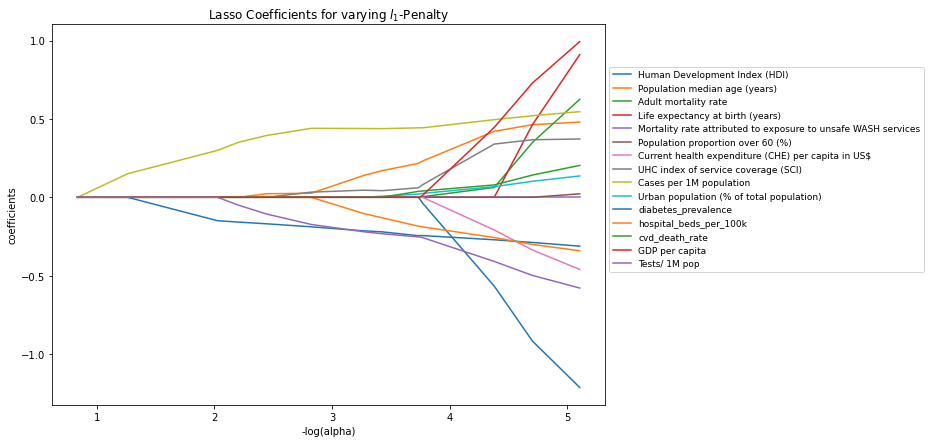

In [ ]:
##############################################################################
#Lasso heuristics
##############################################################################

#define X and y variable set
X = np.array(jhu.iloc[:,2:])
y = np.array(jhu.iloc[:,1])

#standardize data
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)
y = StandardScaler().fit(y.reshape(-1,1)).transform(y.reshape(-1,1)).ravel()

#apply Lasso path
from sklearn.linear_model import lars_path
alphas, active, coef_path_lars = lars_path(X, y, method='lasso')

#define pd data frame with active coefficients
var_sel = pd.DataFrame(coef_path_lars, index = jhu.columns[2:],
                       columns = onp.vectorize(lambda x: "alpha= "+str(round(x,2)))(alphas))    

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

for i in range(var_sel.shape[0]):
    ax.plot(-np.log(alphas[:-1]), var_sel.iloc[i,:-1])

plt.title("Lasso Coefficients for varying $l_1$-Penalty")
plt.xlabel("-log(alpha)")
plt.ylabel("coefficients")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.99, box.height])

# Put a legend to the right of the current axis
ax.legend(jhu.columns[2:], bbox_to_anchor=(1.0, 0.9),fontsize=9)
plt.show()


With varying degrees of $l_1$-penalty, the Lasso selects the following variables in the following order:

In [ ]:
pd.DataFrame(jhu.columns[2:][active], columns = ["Lasso Selection"])

Lasso Selection
0                             Cases per 1M population
1                                 diabetes_prevalence
2                                       Tests/ 1M pop
3                       Population median age (years)
4                 UHC index of service coverage (SCI)
5                              hospital_beds_per_100k
6            Urban population (% of total population)
7                                      cvd_death_rate
8                       Human Development Index (HDI)
9                                Adult mortality rate
10                                     GDP per capita
11  Current health expenditure (CHE) per capita in...
12                   Life expectancy at birth (years)
13                  Population proportion over 60 (%)
14  Mortality rate attributed to exposure to unsaf...

Based on this Lasso-based variable selection process, has idenitfied the following variables as important:

* Number of Coronavirus cases per capita, 
* The diabetes prevalance,
* Coronavirus testing rate.

Remarkably, the Lasso identified both Covid-19 related indicators. This makes intuitive sense. With a low Coronavirus testing rate, more severe cases are being tested, introducing a positive bias in the Covid19 mortatility. 

Next, we will apply the SKIM method to our data set to obtain an alternative set of relevant variables.

We found that the out-of-the box hyperparameters given in the example code for the toy sparsity problem were unable to capture the massive variance in parameter prediction that we recovered after a couple of naive runs. The result was no reported active dimensions or pairwise interactions, even though the data possess strong qualitatively-correlated trends.

To mitigate this, we ran a Sequential Model-Based Optimization scheme on the Inverse Gamma hyperparameters using the package HyperOpt on an HPC cluster. We probed log-uniform hyperparameter space, making $-\exp(N_{\rm active})$ our loss criterion, where

$$N_{\rm active} = \text{num active dims + num pairwise active dims}$$

We also relax the built-in criterion for counting active dimensions to be a well-sampled distribution (no zero bins) within $\pm1.5 \sigma$ of the mean of the parameter contour estimate. The result of our optimization run was a set of rather unintuitive hyperparameters. Our Inverse Gamma location parameters $\alpha_1,  \alpha_2$, and $\alpha_3$
were found to be relatively small, while the parameter $\alpha_{\rm obs}$ needed to be much much larger ($\sim 50$) to recover any active dimensions over 540 optimization trials. 

Below we run the optimized inference over COVID-19 data with different $\pm\sigma$ criterion. We recover the most intuitive set of Case Fatality-causing factors when using the bounds $\sigma = 1.5$.

We run SKIM for $\sigma = 3, 2, 1.5, 1$ below with 5000 samples.

In [ ]:
short_labels = ['HDI', 'PMA', 'AMR', 'LEB', 'wash', 'over-60', 'CHE', 'UHC', 'cases / 1M', 
                'urban', 'diabetes', 'hbeds', 'cvd_dr', 'GDP', 'tests / 1M']

pd.DataFrame(zip(jhu.columns[2:].tolist(), short_labels), columns=['Variable', 'Short Label'])

Variable Short Label
0                       Human Development Index (HDI)         HDI
1                       Population median age (years)         PMA
2                                Adult mortality rate         AMR
3                    Life expectancy at birth (years)         LEB
4   Mortality rate attributed to exposure to unsaf...        wash
5                   Population proportion over 60 (%)     over-60
6   Current health expenditure (CHE) per capita in...         CHE
7                 UHC index of service coverage (SCI)         UHC
8                             Cases per 1M population  cases / 1M
9            Urban population (% of total population)       urban
10                                diabetes_prevalence    diabetes
11                             hospital_beds_per_100k       hbeds
12                                     cvd_death_rate      cvd_dr
13                                     GDP per capita         GDP
14                                      Tests/ 1M pop  tests / 1M

In [ ]:
# Optimised hyperparameters
hypers = {'alpha1': 0.26872577050471647, 
          'alpha2': 4.818866884657901, 
          'alpha3': 6.812836016637205, 
          'alpha_obs': 49.093191654133754,   # this appears to be the key difference
          'beta1': 1.2942745182532156, 
          'beta2': 0.21267247881371867, 
          'beta_obs': 3.3406960438157594, 
          'c': 2.751017838090896}

# Numpyro args
n_data, n_dimensions = X.shape

parser = argparse.ArgumentParser(description="Gaussian Process example")
parser.add_argument("-n", "--num-samples", nargs="?", default=5000, type=int)
parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
parser.add_argument("--num-chains", nargs='?', default=1, type=int)
parser.add_argument("--num-data", nargs='?', default=n_data, type=int)
parser.add_argument("--num-dimensions", nargs='?', default=n_dimensions, type=int)
parser.add_argument("--active-dimensions", nargs='?', default=3, type=int)
parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')
args = parser.parse_args(args=[])

numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)

## $\sigma = 3$

In [ ]:
all_active_dimensions, thetas, labels, pair_labs = main_modified(X=X, Y=y, args=args, sigma=3.0, N_samps=5000, 
                                                                 labels=short_labels, **hypers)


sample: 100%|██████████| 5500/5500 [00:52<00:00, 104.12it/s, 15 steps of size 2.33e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      3.38      4.15      2.06      0.26      7.20   1105.52      1.00
 lambda[0]     13.93    206.57      1.79      0.02     10.63   1714.28      1.00
 lambda[1]      7.00     50.90      1.54      0.00      9.31   3645.37      1.00
 lambda[2]    300.01  14752.30      1.35      0.01      7.34   2500.84      1.00
 lambda[3]      4.19     17.24      1.21      0.00      7.01   3368.72      1.00
 lambda[4]     19.44   1023.71      0.44      0.00      3.85   4129.63      1.00
 lambda[5]      4.15     36.03      0.63      0.00      4.52   2854.07      1.00
 lambda[6]     13.10    325.22      1.55      0.04      9.55   3311.81      1.00
 lambda[7]      7.81     94.99      1.36      0.04      7.18   2375.18      1.00
 lambda[8]      8.82    123.34      1.28      0.03      7.84   2024.98      1.00
 lambda[9]      1.97     54.96      0.12      0.00      1.21   4367.32      1.00
lambda[10]      2.94     38

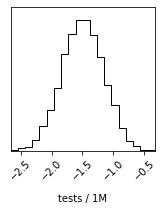

In [ ]:
labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)
fig.show()

In [ ]:
print('Active dimensions:', labs)

Active dimensions: ['tests / 1M']


## $\sigma = 2$

In [ ]:
all_active_dimensions, thetas, labels, pair_labs = main_modified(X=X, Y=y, args=args, sigma=2.0, N_samps=5000, 
                                                                 labels=short_labels, **hypers)


sample: 100%|██████████| 5500/5500 [00:41<00:00, 131.94it/s, 15 steps of size 2.41e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      3.51      4.42      2.08      0.20      7.32    747.07      1.00
 lambda[0]     23.25    452.41      1.78      0.01     10.85   1453.65      1.00
 lambda[1]      7.00     67.61      1.55      0.01      9.48   4483.16      1.00
 lambda[2]    121.94   5907.21      1.35      0.00      7.29   2611.16      1.00
 lambda[3]      4.48     27.25      1.19      0.00      6.83   3831.72      1.00
 lambda[4]      4.92    103.83      0.44      0.00      3.56   2887.68      1.00
 lambda[5]      3.98     41.79      0.63      0.00      4.64   3070.82      1.00
 lambda[6]      9.70     88.28      1.52      0.03     10.37   3008.38      1.00
 lambda[7]      4.71     27.18      1.39      0.04      7.62   3249.94      1.00
 lambda[8]      6.91     53.79      1.23      0.02      6.97   1416.95      1.00
 lambda[9]      2.79     63.51      0.13      0.00      1.34   4655.17      1.00
lambda[10]      2.34     18

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


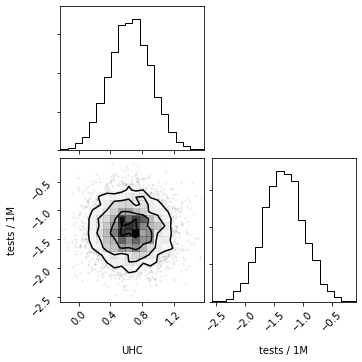

In [ ]:
labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)
fig.show()

In [ ]:
print('Active dimensions:', labs)

Active dimensions: ['UHC', 'tests / 1M']


## $\sigma = 1.5$

In [ ]:
all_active_dimensions, thetas, labels, pair_labs = main_modified(X=X, Y=y, args=args, sigma=1.5, N_samps=5000, 
                                                                 labels=short_labels, **hypers)


sample: 100%|██████████| 5500/5500 [00:52<00:00, 104.57it/s, 15 steps of size 2.33e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      3.38      4.15      2.06      0.26      7.20   1105.52      1.00
 lambda[0]     13.93    206.57      1.79      0.02     10.63   1714.28      1.00
 lambda[1]      7.00     50.90      1.54      0.00      9.31   3645.37      1.00
 lambda[2]    300.01  14752.30      1.35      0.01      7.34   2500.84      1.00
 lambda[3]      4.19     17.24      1.21      0.00      7.01   3368.72      1.00
 lambda[4]     19.44   1023.71      0.44      0.00      3.85   4129.63      1.00
 lambda[5]      4.15     36.03      0.63      0.00      4.52   2854.07      1.00
 lambda[6]     13.10    325.22      1.55      0.04      9.55   3311.81      1.00
 lambda[7]      7.81     94.99      1.36      0.04      7.18   2375.18      1.00
 lambda[8]      8.82    123.34      1.28      0.03      7.84   2024.98      1.00
 lambda[9]      1.97     54.96      0.12      0.00      1.21   4367.32      1.00
lambda[10]      2.94     38

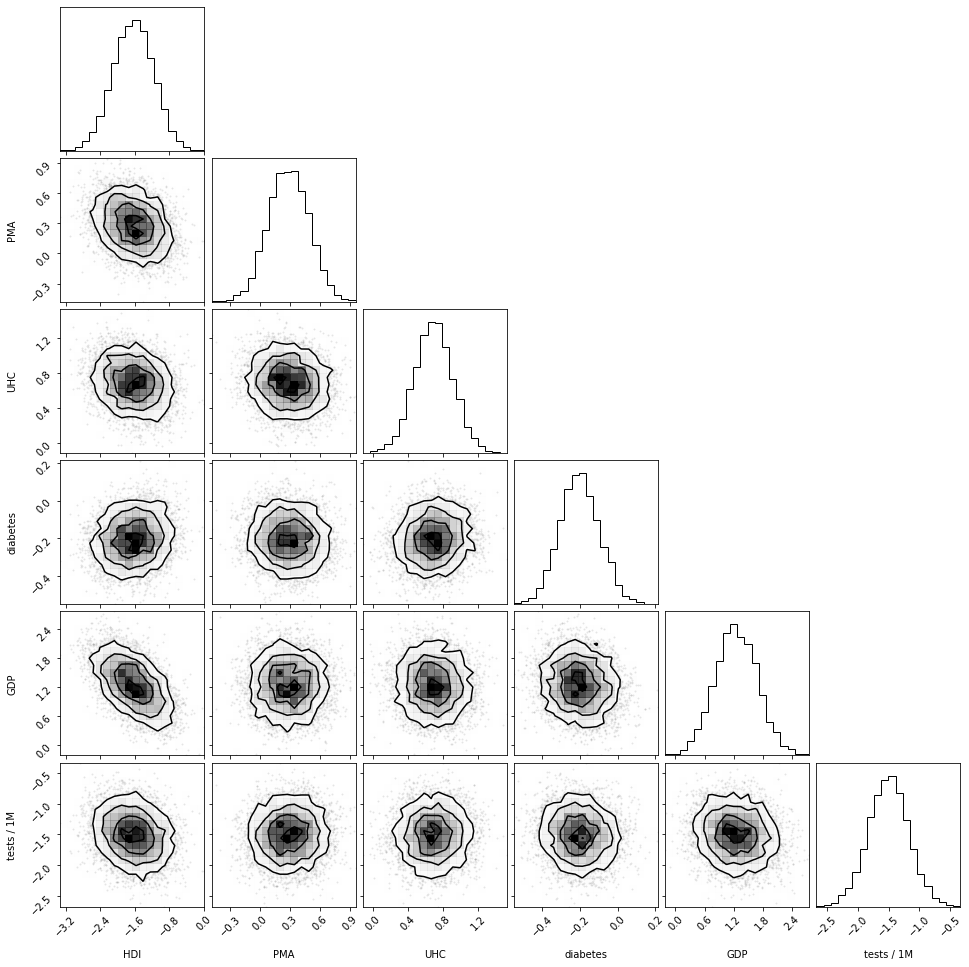

In [ ]:
labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)
fig.show()

In [ ]:
print('Active dimensions:', labs)

Active dimensions: ['HDI', 'PMA', 'UHC', 'diabetes', 'GDP', 'tests / 1M']


## $\sigma = 1.0$

In [ ]:
all_active_dimensions, thetas, labels, pair_labs = main_modified(X=X, Y=y, args=args, sigma=1.0, N_samps=5000, 
                                                                 labels=short_labels, **hypers)


sample: 100%|██████████| 5500/5500 [00:34<00:00, 160.12it/s, 15 steps of size 2.41e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      3.51      4.42      2.08      0.20      7.32    747.07      1.00
 lambda[0]     23.25    452.41      1.78      0.01     10.85   1453.65      1.00
 lambda[1]      7.00     67.61      1.55      0.01      9.48   4483.16      1.00
 lambda[2]    121.94   5907.21      1.35      0.00      7.29   2611.16      1.00
 lambda[3]      4.48     27.25      1.19      0.00      6.83   3831.72      1.00
 lambda[4]      4.92    103.83      0.44      0.00      3.56   2887.68      1.00
 lambda[5]      3.98     41.79      0.63      0.00      4.64   3070.82      1.00
 lambda[6]      9.70     88.28      1.52      0.03     10.37   3008.38      1.00
 lambda[7]      4.71     27.18      1.39      0.04      7.62   3249.94      1.00
 lambda[8]      6.91     53.79      1.23      0.02      6.97   1416.95      1.00
 lambda[9]      2.79     63.51      0.13      0.00      1.34   4655.17      1.00
lambda[10]      2.34     18

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


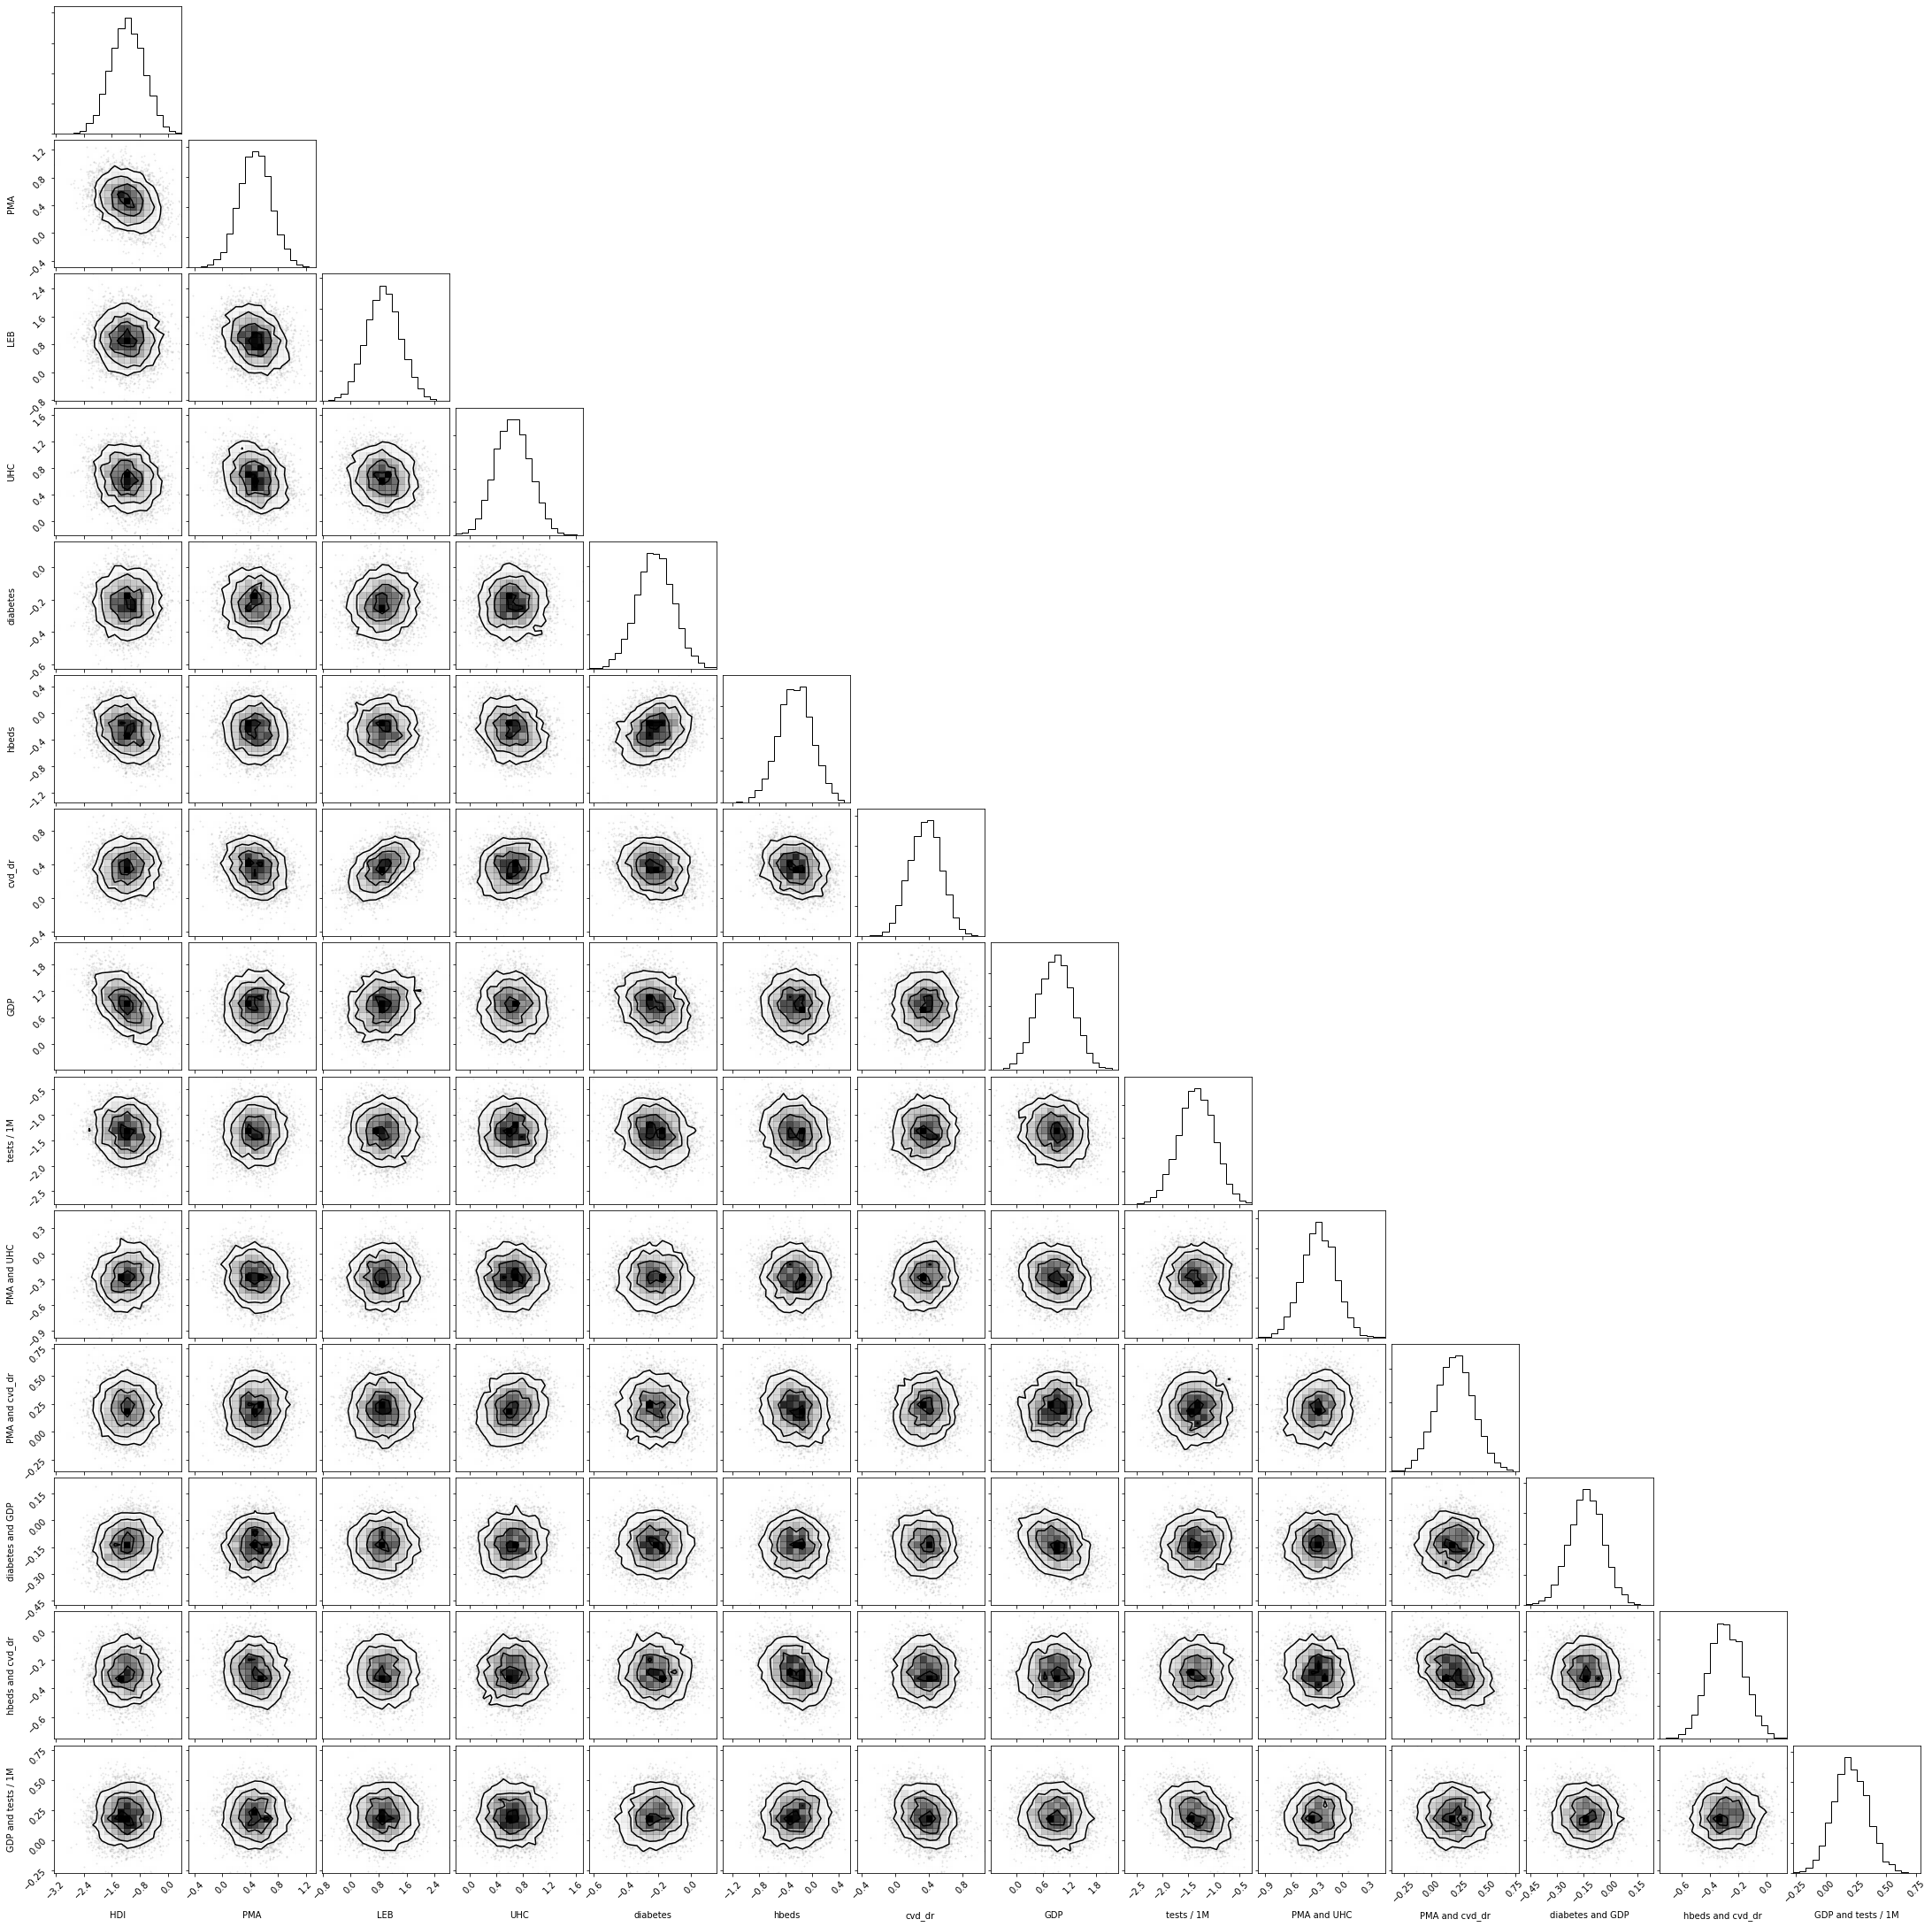

In [ ]:
labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)
fig.show()

In [ ]:
print('Active dimensions:', labs)

Active dimensions: ['HDI', 'PMA', 'LEB', 'UHC', 'diabetes', 'hbeds', 'cvd_dr', 'GDP', 'tests / 1M', 'PMA and UHC', 'PMA and cvd_dr', 'diabetes and GDP', 'hbeds and cvd_dr', 'GDP and tests / 1M']


### Conclusion
From our exploratory COVID-19 study, we were able to recover several active factors in our assembled dataset that help explain case fatality in different countries around the world. Making use of our $\pm 1.5\sigma$ bound in the last plot, we see that intuitive factors, such as Human Development Index (HDI) and diabetes prevalence contribute to higher fatality. 

With the $\pm 1\sigma$ bound we identify 5 pairwise interactions and 9 singular interactions. What is interesting about this result is that we identify very frequent (2) interaction between the country's GDP per captia and other effects, hinting at an underlying explanation for otherwise poor health in those countries.

When we restrict our active dimension contour range to $\pm 2\sigma$, we recover just two active dimensions: the UHC health service coverage score and the availability of tests per 1 million people in the population. For a more comprehensive study, our data could be further weighted by the availability of tests, such that we do not recover biased fatality estimates from countries with more readily-available testing (unlike the US). 

***

### Bonus challenge (2pts extra):

Find another application (e.g. from your area of research) where the kernel-interaction method is directly applicable, or could be applied with some modification. Describe the application for a statistically knowledgeable but non-expert audience (think: your peers in SML 515). In particular, explain why the sparse interaction ansatz is justified. Then demonstrate the use with a suitable data set of your own choice.

**Note:** If your description is convincing, but you don't find any data or it doesn't lead to conclusive results, partial points will be awarded. Make sure that you have permission to use the data and include it as separate file in your submission.

***

## Bonus Challenge Response

Another area where the SKIM is applicable is in volatility forecasting for financial time series. In finance, volatility is generally understood to mean a measure of the variation of the price of an asset through time. Higher variation means higher volatility. It is an important quantity for pricing models and risk management, so the ability to accurately forecast future volatility is a useful task.

To that end, volatilities of different assets can often be correlated and volatility time series themselves generally display high levels of autocorrelation. This last part means that the correlation is high between the current value in a volatility time series and past values. Taken together, these features mean that there is predictive power in the autoregressive lags and in the cross-section of volatilities of financial assets.

Thus, the task in this section is to forecast one-day-ahead volatility of the exchange rate between euro (EUR) and British pound sterling (GBP): EURGBP. The regressors for this problem will lags of realised volatility and implied volatility of 16 different currency pairs. Realised volatility is the actual volatility of the past days' time series of the exchange rates. Implied volatility is a value obtained from options markets. Without getting bogged down in the details, options are contracts that give the holders the right to buy or sell an asset at a specified price--they provide certainty. Their prices are related to expectations of future volatility by a famous relationship called the Black-Scholes equation, which is essentially a reformulation of the classical drift-diffusion PDEs in physics. For the purposes here, we can understand implied volatility to be the expected future volatility implied by option prices in the market. Thus, it is a useful regressor for our problem of forecasting future volatility.

We can see the target variable in the first column and the set of regressors in the rest of the columns of the below data frame.


In [ ]:
# Read in the data
fxdata = pd.read_csv('fxdata.csv', header=0)

# Subset the rows and columns
df = fxdata.copy()
df = df.iloc[-64:,:]
drop_cols = list(df.columns[df.columns.str.contains('Dummy')])
drop_cols = drop_cols + list(df.columns[df.columns.str.contains('LogReturn')])
drop_cols = drop_cols + list(df.columns[df.columns.str.contains('Spot')])
df.drop(drop_cols, axis=1, inplace=True)

# Set the target variable and shift it ahead by one day
target_col = 'EURGBP_log_RealVol'
df['Target_' + target_col] = df[target_col].shift(1).copy()
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Target_' + target_col)))
df = df[cols].set_index('Date').dropna()

# Standardise each column
df[df.columns] = StandardScaler().fit_transform(df)

In [ ]:
df.head()

Target_EURGBP_log_RealVol  AUDJPY_log_ImplVol1d  \
Date                                                          
2019-12-31                  -0.382606             -1.113089   
2020-01-02                  -0.210221             -0.984138   
2020-01-03                  -0.445465             -1.366099   
2020-01-06                  -0.530039             -0.567261   
2020-01-07                  -0.830431             -0.748562   

            AUDJPY_log_ImplVol1d_HAR22  AUDJPY_log_ImplVol1d_HAR5  \
Date                                                                
2019-12-31                   -0.857241                  -1.390873   
2020-01-02                   -0.823987                  -1.193571   
2020-01-03                   -0.866473                  -1.247583   
2020-01-06                   -0.863042                  -0.984663   
2020-01-07                   -0.869974                  -0.943429   

            AUDJPY_log_ImplVol1m  AUDJPY_log_ImplVol1m_HAR22  \
Date                                                           
2019-12-31             -0.807958                   -0.843128   
2020-01-02             -0.811705                   -0.825481   
2020-01-03             -0.702246                   -0.804847   
2020-01-06             -0.623899                   -0.788618   
2020-01-07             -0.706986                   -0.782303   

            AUDJPY_log_ImplVol1m_HAR5  AUDJPY_log_RealVol  \
Date                                                        
2019-12-31                  -0.941674           -1.359974   
2020-01-02                  -0.879132           -1.123296   
2020-01-03                  -0.800335           -0.443139   
2020-01-06                  -0.720086           -0.718948   
2020-01-07                  -0.682762           -0.624565   

            AUDJPY_log_RealVol_HAR22  AUDJPY_log_RealVol_HAR5  ...  \
Date                                                           ...   
2019-12-31                 -1.043436                -1.518471  ...   
2020-01-02                 -1.027466                -1.416277  ...   
2020-01-03                 -0.976796                -1.053005  ...   
2020-01-06                 -0.992457                -0.950720  ...   
2020-01-07                 -0.980799                -0.820193  ...   

            USDCHF_log_RealVol_HAR5  USDJPY_log_ImplVol1d  \
Date                                                        
2019-12-31                -0.972054             -0.897603   
2020-01-02                -0.663547             -0.693473   
2020-01-03                -0.422177             -0.933149   
2020-01-06                -0.443892             -0.496679   
2020-01-07                -0.460334             -0.699712   

            USDJPY_log_ImplVol1d_HAR22  USDJPY_log_ImplVol1d_HAR5  \
Date                                                                
2019-12-31                   -0.796031                  -1.299435   
2020-01-02                   -0.756117                  -1.053805   
2020-01-03                   -0.769495                  -1.000837   
2020-01-06                   -0.773760                  -0.769779   
2020-01-07                   -0.773667                  -0.715646   

            USDJPY_log_ImplVol1m  USDJPY_log_ImplVol1m_HAR22  \
Date                                                           
2019-12-31             -0.627827                   -0.758041   
2020-01-02             -0.762690                   -0.745066   
2020-01-03             -0.582873                   -0.729509   
2020-01-06             -0.656583                   -0.735486   
2020-01-07             -0.745540                   -0.742096   

            USDJPY_log_ImplVol1m_HAR5  USDJPY_log_RealVol  \
Date                                                        
2019-12-31                  -0.916504           -1.135485   
2020-01-02                  -0.825872           -0.748236   
2020-01-03                  -0.714918           -0.071412   
2020-01-06                  -0.646684           -0.6

Given there are 145 regressors here, it is unlikely that all are relevant for this forecasting problem. Furthermore, since all the observations are concurrent (each row corresponds to that regressors value at 17:00 ET on that date), there are clearly potential interactions between the regressors, because financial markets (especially currency markets) usually move together. If markets are generally volatile on a given day, then we expect all the regressors' values to be higher. Therefore, it seems reasonable to use SKIM with this dataset and see if we obtain any interesting results. This is, of course, not an out-of-sample testing procedure below, but it is still interesting to see if there are any insights about the most relevant regressors or interactions.

In [ ]:
X = df.iloc[:,1:].to_numpy(copy=True)
y = df.iloc[:,0].to_numpy(copy=True)
short_labels = df.columns.tolist()[1:]

# Optimised hyperparameters
hypers = {'alpha1': 3.122537300650637, 
          'alpha2': 34.09492602758983, 
          'alpha3': 18.300149226065756, 
          'alpha_obs': 47.62800372787773, 
          'beta1': 13.485881358212492, 
          'beta2': 0.10054579153997745, 
          'beta_obs': 0.16307865726277268, 
          'c': 0.5174410338358931}

# Numpyro args
n_data, n_dimensions = X.shape

parser = argparse.ArgumentParser(description="Gaussian Process example")
parser.add_argument("-n", "--num-samples", nargs="?", default=5000, type=int)
parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
parser.add_argument("--num-chains", nargs='?', default=1, type=int)
parser.add_argument("--num-data", nargs='?', default=n_data, type=int)
parser.add_argument("--num-dimensions", nargs='?', default=n_dimensions, type=int)
parser.add_argument("--active-dimensions", nargs='?', default=3, type=int)
parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')
args = parser.parse_args(args=[])

numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)

## $\sigma = 2$

In [ ]:
all_active_dimensions, thetas, labels, pair_labs = main_modified(X=X, Y=y, args=args, sigma=2.0, N_samps=5000, 
                                                                 labels=short_labels, **hypers)


sample: 100%|██████████| 5500/5500 [00:57<00:00, 95.80it/s, 31 steps of size 2.12e-01. acc. prob=0.90]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.30      0.08      0.29      0.18      0.42   2621.14      1.00
  lambda[0]      6.04    104.00      1.02      0.00      5.63   2468.33      1.00
  lambda[1]      8.29    133.87      1.01      0.00      6.68   2471.60      1.00
  lambda[2]      4.86     28.23      1.05      0.00      6.69   3196.49      1.00
  lambda[3]    231.21  10434.69      8.06      0.00     48.10   4415.06      1.00
  lambda[4]      3.39     16.13      0.96      0.00      5.47   4469.30      1.00
  lambda[5]      4.86     54.22      0.92      0.00      4.90   3251.43      1.00
  lambda[6]     11.21    129.33      1.10      0.00     10.49   3385.64      1.00
  lambda[7]      7.77     55.05      1.29      0.00     11.73   3761.46      1.00
  lambda[8]      2.31     10.67      0.79      0.00      3.94   3106.93      1.00
  lambda[9]      9.27    118.05      1.31      0.00      6.32   1389.63      1.00
 lambda[10]    

[dimension 01/144]  inactive:	-2.07e-01 +- 3.10e-01
[dimension 02/144]  inactive:	-1.32e-01 +- 5.51e-01
[dimension 03/144]  inactive:	2.34e-01 +- 5.36e-01
[dimension 04/144]  active:	1.94e+00 +- 9.22e-01
[dimension 05/144]  inactive:	-1.09e-02 +- 5.29e-01
[dimension 06/144]  inactive:	-2.26e-02 +- 4.78e-01
[dimension 07/144]  inactive:	-1.58e-02 +- 2.29e-01
[dimension 08/144]  inactive:	4.04e-01 +- 7.74e-01
[dimension 09/144]  inactive:	-5.74e-02 +- 3.38e-01
[dimension 10/144]  inactive:	-3.11e-01 +- 3.10e-01
[dimension 11/144]  inactive:	-2.35e-01 +- 6.14e-01
[dimension 12/144]  inactive:	-1.44e-01 +- 4.56e-01
[dimension 13/144]  inactive:	-1.68e-02 +- 3.78e-01
[dimension 14/144]  inactive:	-2.88e-02 +- 5.07e-01
[dimension 15/144]  inactive:	-4.95e-02 +- 4.76e-01
[dimension 16/144]  inactive:	-5.90e-01 +- 3.23e-01
[dimension 17/144]  inactive:	1.15e-01 +- 5.68e-01
[dimension 18/144]  inactive:	-3.91e-02 +- 3.65e-01
[dimension 19/144]  inactive:	-5.05e-02 +- 2.08e-01
[dimension 20/144]

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


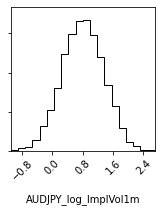

In [ ]:
labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)
fig.show()

In [ ]:
print('Active dimensions:', labs)

Active dimensions: ['AUDJPY_log_ImplVol1m']


## $\sigma = 1.5$

In [ ]:
all_active_dimensions, thetas, labels, pair_labs = main_modified(X=X, Y=y, args=args, sigma=1.5, N_samps=5000, 
                                                                 labels=short_labels, **hypers)


sample: 100%|██████████| 5500/5500 [00:52<00:00, 103.81it/s, 31 steps of size 2.12e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.30      0.08      0.29      0.18      0.42   2621.14      1.00
  lambda[0]      6.04    104.00      1.02      0.00      5.63   2468.33      1.00
  lambda[1]      8.29    133.87      1.01      0.00      6.68   2471.60      1.00
  lambda[2]      4.86     28.23      1.05      0.00      6.69   3196.49      1.00
  lambda[3]    231.21  10434.69      8.06      0.00     48.10   4415.06      1.00
  lambda[4]      3.39     16.13      0.96      0.00      5.47   4469.30      1.00
  lambda[5]      4.86     54.22      0.92      0.00      4.90   3251.43      1.00
  lambda[6]     11.21    129.33      1.10      0.00     10.49   3385.64      1.00
  lambda[7]      7.77     55.05      1.29      0.00     11.73   3761.46      1.00
  lambda[8]      2.31     10.67      0.79      0.00      3.94   3106.93      1.00
  lambda[9]      9.27    118.05      1.31      0.00      6.32   1389.63      1.00
 lambda[10]    

[dimension 01/144]  inactive:	-2.07e-01 +- 3.10e-01
[dimension 02/144]  inactive:	-1.32e-01 +- 5.51e-01
[dimension 03/144]  inactive:	2.34e-01 +- 5.36e-01
[dimension 04/144]  active:	1.94e+00 +- 9.22e-01
[dimension 05/144]  inactive:	-1.09e-02 +- 5.29e-01
[dimension 06/144]  inactive:	-2.26e-02 +- 4.78e-01
[dimension 07/144]  inactive:	-1.58e-02 +- 2.29e-01
[dimension 08/144]  inactive:	4.04e-01 +- 7.74e-01
[dimension 09/144]  inactive:	-5.74e-02 +- 3.38e-01
[dimension 10/144]  inactive:	-3.11e-01 +- 3.10e-01
[dimension 11/144]  inactive:	-2.35e-01 +- 6.14e-01
[dimension 12/144]  inactive:	-1.44e-01 +- 4.56e-01
[dimension 13/144]  inactive:	-1.68e-02 +- 3.78e-01
[dimension 14/144]  inactive:	-2.88e-02 +- 5.07e-01
[dimension 15/144]  inactive:	-4.95e-02 +- 4.76e-01
[dimension 16/144]  active:	-5.90e-01 +- 3.23e-01
[dimension 17/144]  inactive:	1.15e-01 +- 5.68e-01
[dimension 18/144]  inactive:	-3.91e-02 +- 3.65e-01
[dimension 19/144]  inactive:	-5.05e-02 +- 2.08e-01
[dimension 20/144]  

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


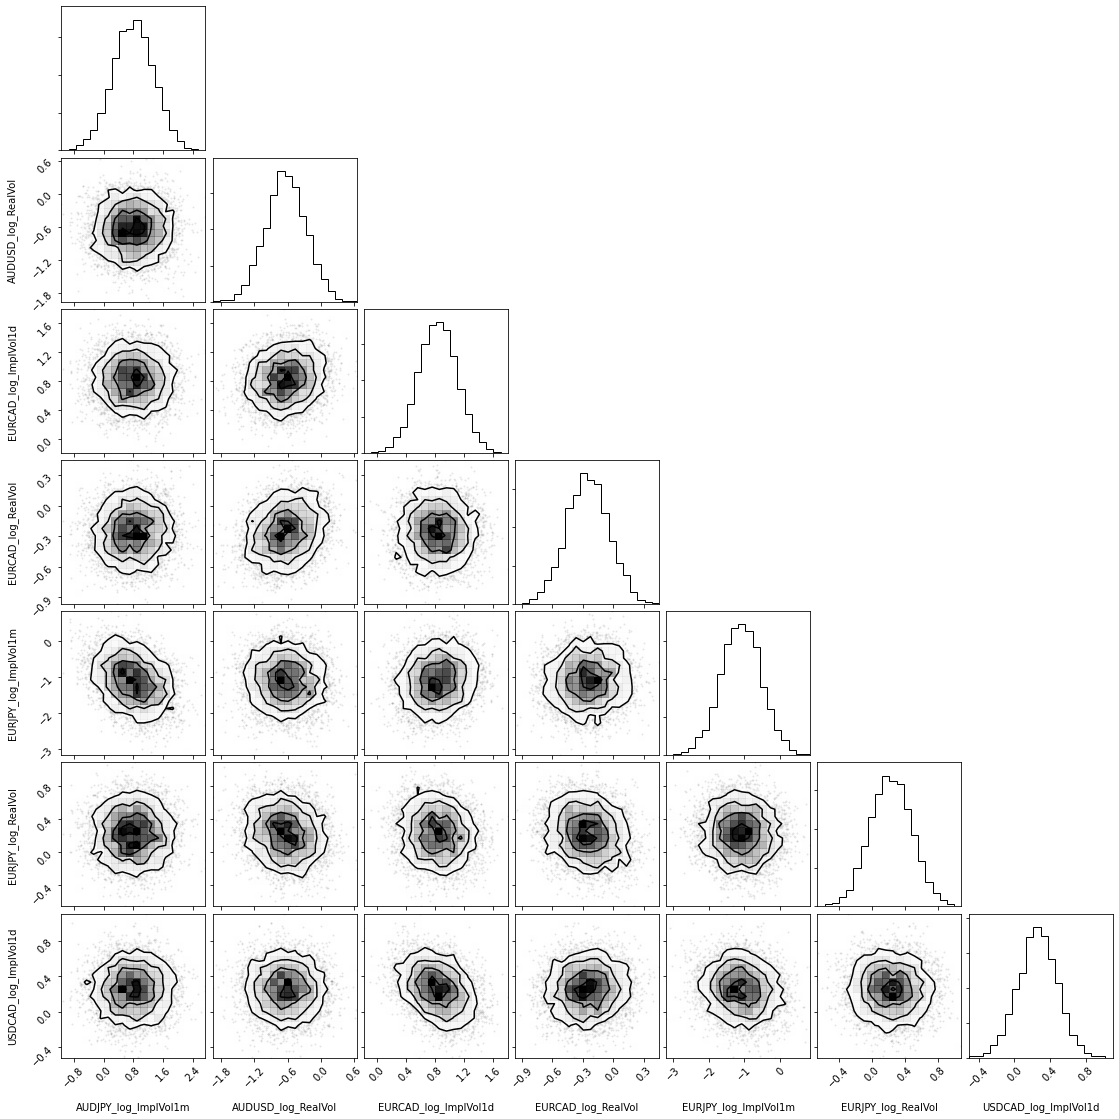

In [ ]:
labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)
fig.show()

In [ ]:
print('Active dimensions:', labs)

Active dimensions: ['AUDJPY_log_ImplVol1m', 'AUDUSD_log_RealVol', 'EURCAD_log_ImplVol1d', 'EURCAD_log_RealVol', 'EURJPY_log_ImplVol1m', 'EURJPY_log_RealVol', 'USDCAD_log_ImplVol1d']


## $\sigma = 1.0$

In [ ]:
all_active_dimensions, thetas, labels, pair_labs = main_modified(X=X, Y=y, args=args, sigma=1.0, N_samps=5000, 
                                                                 labels=short_labels, **hypers)


sample: 100%|██████████| 5500/5500 [01:08<00:00, 80.81it/s, 31 steps of size 2.12e-01. acc. prob=0.90]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.30      0.08      0.29      0.18      0.42   2621.14      1.00
  lambda[0]      6.04    104.00      1.02      0.00      5.63   2468.33      1.00
  lambda[1]      8.29    133.87      1.01      0.00      6.68   2471.60      1.00
  lambda[2]      4.86     28.23      1.05      0.00      6.69   3196.49      1.00
  lambda[3]    231.21  10434.69      8.06      0.00     48.10   4415.06      1.00
  lambda[4]      3.39     16.13      0.96      0.00      5.47   4469.30      1.00
  lambda[5]      4.86     54.22      0.92      0.00      4.90   3251.43      1.00
  lambda[6]     11.21    129.33      1.10      0.00     10.49   3385.64      1.00
  lambda[7]      7.77     55.05      1.29      0.00     11.73   3761.46      1.00
  lambda[8]      2.31     10.67      0.79      0.00      3.94   3106.93      1.00
  lambda[9]      9.27    118.05      1.31      0.00      6.32   1389.63      1.00
 lambda[10]    

[dimension 01/144]  inactive:	-2.07e-01 +- 3.10e-01
[dimension 02/144]  inactive:	-1.32e-01 +- 5.51e-01
[dimension 03/144]  inactive:	2.34e-01 +- 5.36e-01
[dimension 04/144]  active:	1.94e+00 +- 9.22e-01
[dimension 05/144]  inactive:	-1.09e-02 +- 5.29e-01
[dimension 06/144]  inactive:	-2.26e-02 +- 4.78e-01
[dimension 07/144]  inactive:	-1.58e-02 +- 2.29e-01
[dimension 08/144]  inactive:	4.04e-01 +- 7.74e-01
[dimension 09/144]  inactive:	-5.74e-02 +- 3.38e-01
[dimension 10/144]  active:	-3.11e-01 +- 3.10e-01
[dimension 11/144]  inactive:	-2.35e-01 +- 6.14e-01
[dimension 12/144]  inactive:	-1.44e-01 +- 4.56e-01
[dimension 13/144]  inactive:	-1.68e-02 +- 3.78e-01
[dimension 14/144]  inactive:	-2.88e-02 +- 5.07e-01
[dimension 15/144]  inactive:	-4.95e-02 +- 4.76e-01
[dimension 16/144]  active:	-5.90e-01 +- 3.23e-01
[dimension 17/144]  inactive:	1.15e-01 +- 5.68e-01
[dimension 18/144]  inactive:	-3.91e-02 +- 3.65e-01
[dimension 19/144]  inactive:	-5.05e-02 +- 2.08e-01
[dimension 20/144]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


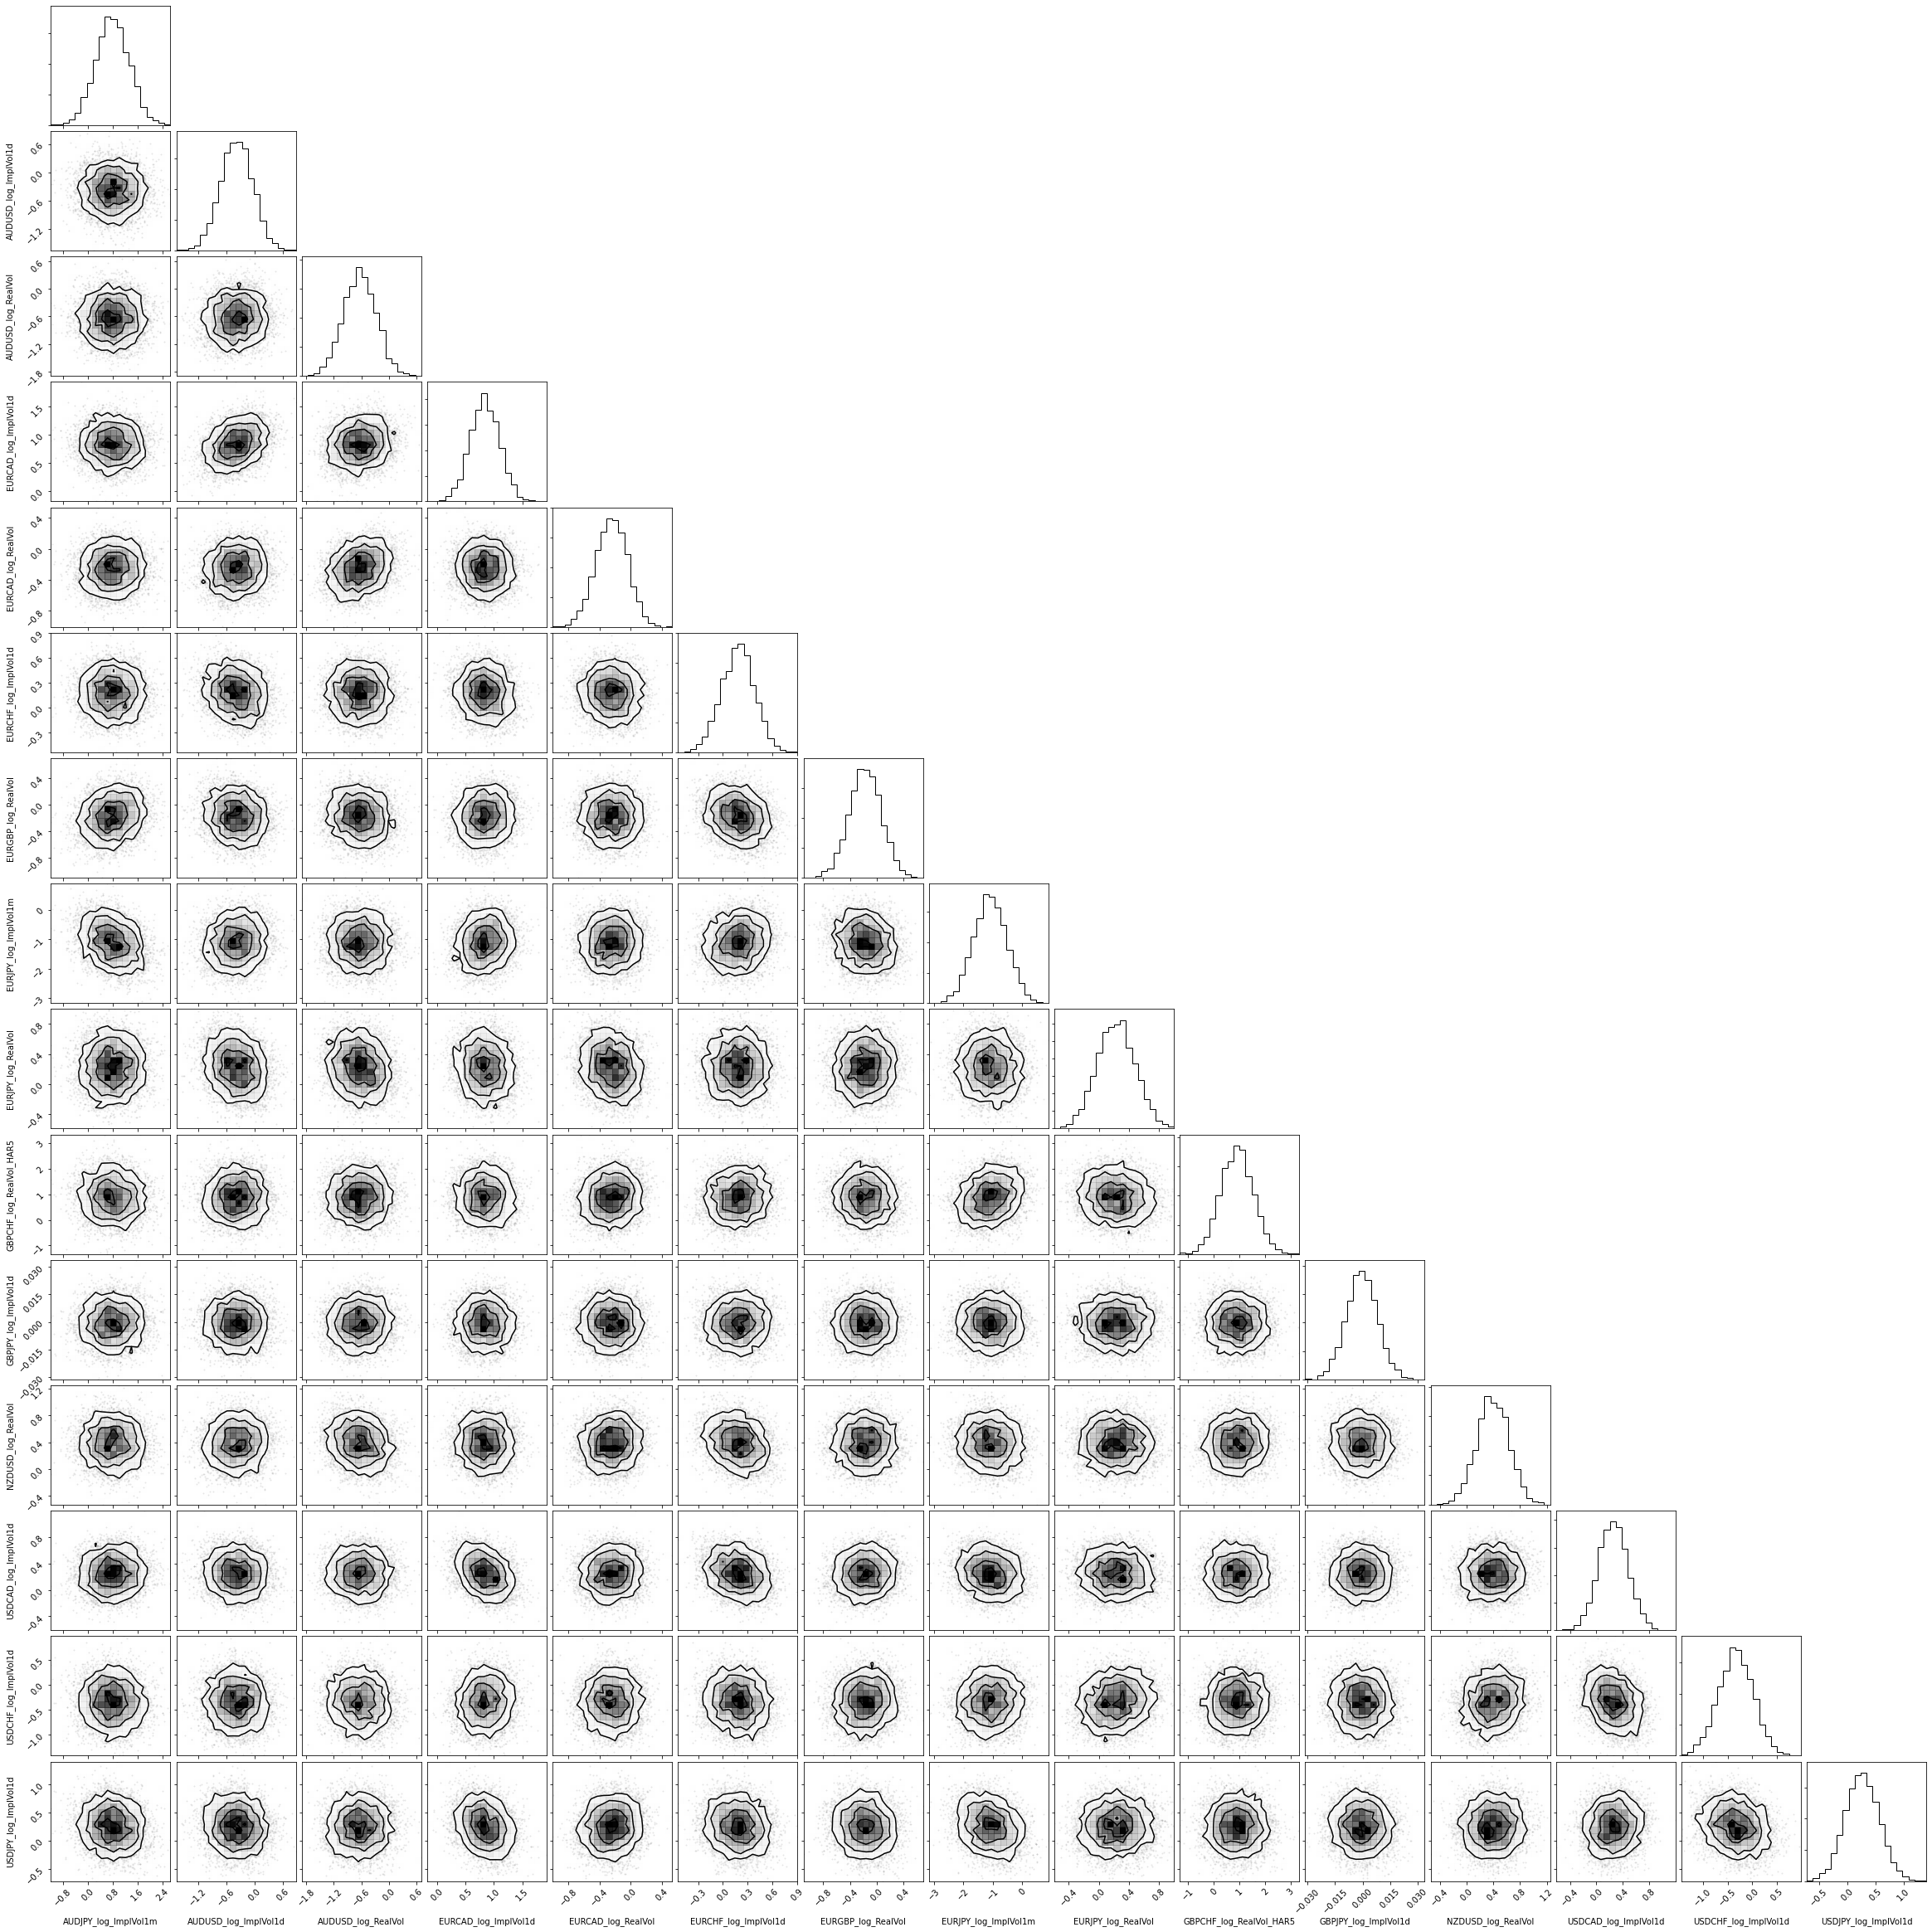

In [ ]:
labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)
fig.show()

In [ ]:
print('Active dimensions:', labs)

Active dimensions: ['AUDJPY_log_ImplVol1m', 'AUDUSD_log_ImplVol1d', 'AUDUSD_log_RealVol', 'EURCAD_log_ImplVol1d', 'EURCAD_log_RealVol', 'EURCHF_log_ImplVol1d', 'EURGBP_log_RealVol', 'EURJPY_log_ImplVol1m', 'EURJPY_log_RealVol', 'GBPCHF_log_RealVol_HAR5', 'GBPJPY_log_ImplVol1d', 'NZDUSD_log_RealVol', 'USDCAD_log_ImplVol1d', 'USDCHF_log_ImplVol1d', 'USDJPY_log_ImplVol1d']


In this exchange rate volatility forecasting experiment, we manage to obtain one active dimension at $\pm 2\sigma$, and it is quite an unusual one as it is the 1-month implied volatility of another currency, AUDJPY. However, these variables are highly correlated as seen in the correlation matrix below. The first principal component of this data frame accounts for 70% of the total variance. Thus, it is possibly less surprising that this regressor was selected, as it could have been almost any of them!

With $\pm 1.5\sigma$ bounds, we are able to recover 7 active dimensions, and none of them are EURGBP values. This is quite surprising as they are regressors from a variety of currency pairs. This again demonstrates the how similar these regressors are.

With $\pm 1\sigma$ bounds, we are able to recover 15 active dimensions, and still there are no EURGBP values.

These results are quite different from those run with LASSO, which are produced below.

In [ ]:
df.corr()

Target_EURGBP_log_RealVol  AUDJPY_log_ImplVol1d  \
Target_EURGBP_log_RealVol                    1.000000              0.856674   
AUDJPY_log_ImplVol1d                         0.856674              1.000000   
AUDJPY_log_ImplVol1d_HAR22                   0.904750              0.873535   
AUDJPY_log_ImplVol1d_HAR5                    0.920098              0.935216   
AUDJPY_log_ImplVol1m                         0.931120              0.945132   
...                                               ...                   ...   
USDJPY_log_ImplVol1m_HAR22                   0.916727              0.872905   
USDJPY_log_ImplVol1m_HAR5                    0.926819              0.931799   
USDJPY_log_RealVol                           0.808212              0.851758   
USDJPY_log_RealVol_HAR22                     0.930606              0.911251   
USDJPY_log_RealVol_HAR5                      0.877524              0.914372   

                            AUDJPY_log_ImplVol1d_HAR22  \
Target_EURGBP_log_RealVol                     0.904750   
AUDJPY_log_ImplVol1d                          0.873535   
AUDJPY_log_ImplVol1d_HAR22                    1.000000   
AUDJPY_log_ImplVol1d_HAR5                     0.957390   
AUDJPY_log_ImplVol1m                          0.920841   
...                                                ...   
USDJPY_log_ImplVol1m_HAR22                    0.988895   
USDJPY_log_ImplVol1m_HAR5                     0.915543   
USDJPY_log_RealVol                            0.779211   
USDJPY_log_RealVol_HAR22                      0.985602   
USDJPY_log_RealVol_HAR5                       0.860501   

                            AUDJPY_log_ImplVol1d_HAR5  AUDJPY_log_ImplVol1m  \
Target_EURGBP_log_RealVol                    0.920098              0.931120   
AUDJPY_log_ImplVol1d                         0.935216              0.945132   
AUDJPY_log_ImplVol1d_HAR22                   0.957390              0.920841   
AUDJPY_log_ImplVol1d_HAR5                    1.000000              0.974080   
AUDJPY_log_ImplVol1m                         0.974080              1.000000   
...                                               ...                   ...   
USDJPY_log_ImplVol1m_HAR22                   0.957673              0.931867   
USDJPY_log_ImplVol1m_HAR5                    0.975895              0.987832   
USDJPY_log_RealVol                           0.844033              0.893671   
USDJPY_log_RealVol_HAR22                     0.982409              0.962075   
USDJPY_log_RealVol_HAR5                      0.940708              0.951568   

                            AUDJPY_log_ImplVol1m_HAR22  \
Target_EURGBP_log_RealVol                     0.898322   
AUDJPY_log_ImplVol1d                          0.846166   
AUDJPY_log_ImplVol1d_HAR22                    0.992699   
AUDJPY_log_ImplVol1d_HAR5                     0.939743   
AUDJPY_log_ImplVol1m                          0.901061   
...                                                ...   
USDJPY_log_ImplVol1m_HAR22                    0.994826   
USDJPY_log_ImplVol1m_HAR5                     0.897337   
USDJPY_log_RealVol                            0.740669   
USDJPY_log_RealVol_HAR22                      0.977561   
USDJPY_log_RealVol_HAR5                       0.827672   

                            AUDJPY_log_ImplVol1m_HAR5  AUDJPY_log_RealVol  \
Target_EURGBP_log_RealVol                    0.944106            0.834454   
AUDJPY_log_ImplVol1d                         0.915300            0.875247   
AUDJPY_log_ImplVol1d_HAR22                   0.964634            0.814800   
AUDJPY_log_ImplVol1d_HAR5                    0.988667            0.883166   
AUDJPY_log_ImplVol1m                         0.975908            0.924791   
...                                               ...                 ...   
USDJPY_log_ImplVol1m_HAR22                   0.974446            0.814008   
USDJPY_log_ImplVol1m_HAR5                    0.976982            0.906374   
USDJPY_log_RealVol                         

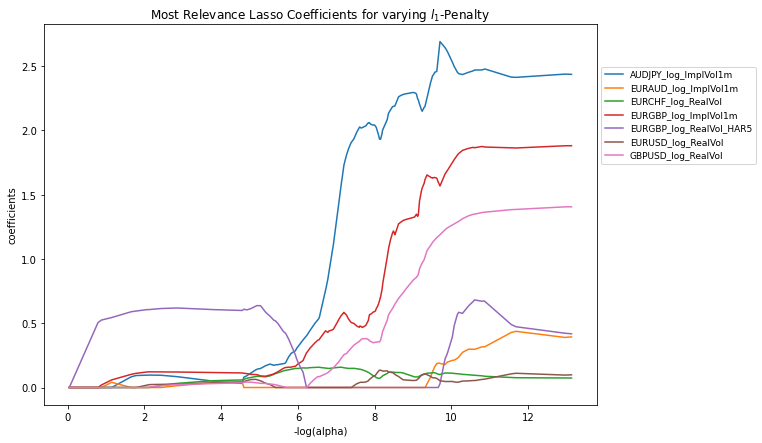

In [ ]:
X = df.iloc[:,1:].to_numpy(copy=True)
y = df.iloc[:,0].to_numpy(copy=True)

#apply Lasso path
alphas, active, coef_path_lars = lars_path(X, y, method='lasso')

#define pd data frame with active coefficients
var_sel = pd.DataFrame(coef_path_lars, index = df.columns[1:],
                       columns = onp.round(alphas,2)) #onp.vectorize(lambda x: "alpha= "+str(round(x,2)))(alphas))    

#keep only the variables which are nonzero when alpha=0.06
var_sel = var_sel.loc[var_sel[0.06] != 0,:]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

for i in range(var_sel.shape[0]):
    ax.plot(-np.log(alphas[:-1]), var_sel.iloc[i,:-1])

plt.title("Most Relevance Lasso Coefficients for varying $l_1$-Penalty")
plt.xlabel("-log(alpha)")
plt.ylabel("coefficients")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.99, box.height])

# Put a legend to the right of the current axis
ax.legend(var_sel.index, bbox_to_anchor=(1.0, 0.9),fontsize=9)
plt.show()


In [ ]:
pd.DataFrame(var_sel.index, columns = ["Relevant Regressors"])

Relevant Regressors
0     AUDJPY_log_ImplVol1m
1     EURAUD_log_ImplVol1m
2       EURCHF_log_RealVol
3     EURGBP_log_ImplVol1m
4  EURGBP_log_RealVol_HAR5
5       EURUSD_log_RealVol
6       GBPUSD_log_RealVol

With LASSO, the AUDJPY_log_ImplVol1m is still important, which is comforting. However, this set of regressors makes more intuitive sense as they are mostly EUR and GBP currency pairs. Regardless, it was also disappointing to not get any interaction terms from the SKIM experiment. Altogether, it seems like an area where SKIM could be used instead of including polynomial features or other indirect methods for including interaction terms.